In [1]:
################################################################################################################################
#
# ECONOMETRIC - ROLLING - LN - MONTHLY
#
################################################################################################################################

In [2]:
#===============================================================================================================================
# ENVIRONMENT: LIBRARIES
#===============================================================================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pmdarima as pmd

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

from typing import Union
from tqdm import tqdm_notebook
#from tqdm.notebook import tqdm

In [3]:
#===============================================================================================================================
# DATA INPUT: PRICES
#===============================================================================================================================
seriesId='IBOV-monthly'
df = pd.read_csv('Data/Input/'+seriesId+'.csv')
#df.drop(['Open','Low','High', 'Qt'], axis='columns', inplace=True )
PERIOD=249
df

,Date,Close
0,28/01/2000,16734.39
1,29/02/2000,17660.20
2,31/03/2000,17820.37
3,28/04/2000,15537.60
4,31/05/2000,14956.61
...,...,...
283,31/08/2023,115741.81
284,29/09/2023,116565.17
285,31/10/2023,113143.67
286,30/11/2023,127331.12


In [4]:
#===============================================================================================================================
# DATA INPUT: PRICES - DATETIME
#===============================================================================================================================
df['Date'] =pd.to_datetime(df['Date'], dayfirst=True)

In [5]:
#===============================================================================================================================
# DATA INPUT: PRICES - SET INDEX
#===============================================================================================================================
df2 = df.set_index('Date')

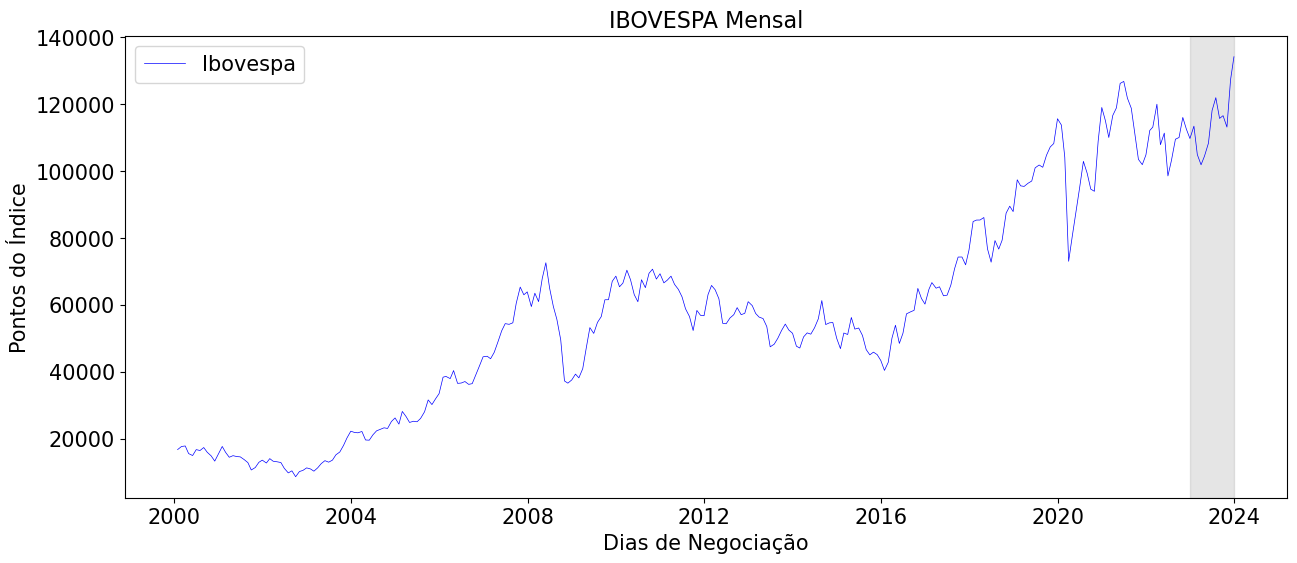

In [6]:
#===============================================================================================================================
# DATA INPUT: PRICES - PLOT
#===============================================================================================================================
plt.figure(figsize=(15,6))
plt.plot(df['Date'], df['Close'], label = 'Ibovespa', color='b', linewidth=0.5)
plt.title('IBOVESPA Mensal', fontsize=16)
plt.xlabel('Dias de Negociação', fontsize=15)
plt.ylabel('Pontos do Índice', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.axvspan('2023', '2024', color='#808080', alpha=0.2)
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))
plt.show()


In [7]:
#===============================================================================================================================
# DATA PREP: LOG
#===============================================================================================================================
dfln = df.copy()
dfln['CloseLn']= np.log(dfln['Close'])

In [8]:
#===============================================================================================================================
# DATA PREP: LOG - SET INDEX
#===============================================================================================================================
dfln2 = dfln.set_index('Date')

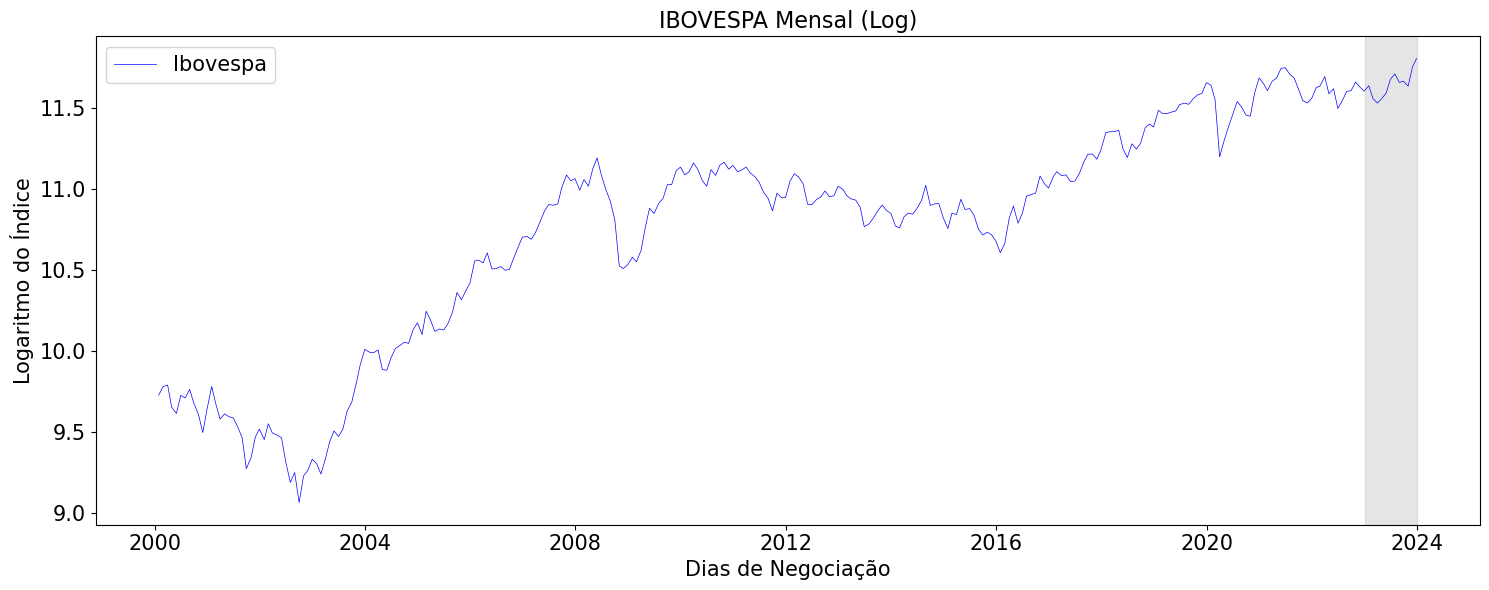

In [9]:
#===============================================================================================================================
# DATA PREP: LOG - PLOT
#===============================================================================================================================
plt.figure(figsize=(15,6))
plt.plot(dfln['Date'], dfln['CloseLn'], 'b-', label = "Ibovespa", linewidth=0.5)
plt.title('IBOVESPA Mensal (Log)', fontsize=16)
plt.xlabel('Dias de Negociação', fontsize=15)
plt.ylabel('Logaritmo do Índice', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.axvspan('2023', '2024', color='#808080', alpha=0.2)
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))
plt.tight_layout()
plt.show()

In [10]:
#===============================================================================================================================
# DATA PREP: LOG-DIFF
#===============================================================================================================================
dfln['CloseLnDiff'] = 0
dfln.loc[1:, ['CloseLnDiff']] = dfln.loc[:, 'CloseLn'].diff()
dfln

,Date,Close,CloseLn,CloseLnDiff
0,2000-01-28,16734.39,9.725221,0.000000
1,2000-02-29,17660.20,9.779069,0.053848
2,2000-03-31,17820.37,9.788097,0.009029
3,2000-04-28,15537.60,9.651018,-0.137079
4,2000-05-31,14956.61,9.612909,-0.038110
...,...,...,...,...
283,2023-08-31,115741.81,11.659117,-0.052192
284,2023-09-29,116565.17,11.666206,0.007089
285,2023-10-31,113143.67,11.636414,-0.029792
286,2023-11-30,127331.12,11.754546,0.118133


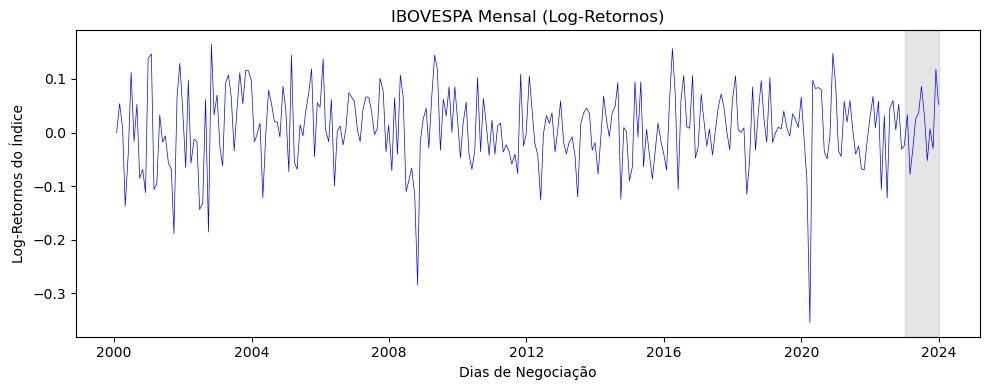

In [11]:
#===============================================================================================================================
# DATA PREP: LOG-DIFF - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
plt.title('IBOVESPA Mensal (Log-Retornos)', fontsize=12)
ax.plot(dfln['Date'], dfln['CloseLnDiff'], 'b-', label = "Ibovespa", linewidth=0.5)
ax.set_xlabel('Dias de Negociação')
ax.set_ylabel('Log-Retornos do Índice')
ax.axvspan('2023', '2024', color='#808080', alpha=0.2)
plt.tight_layout()

In [12]:
#===============================================================================================================================
# DATA PREP: SPLIT
#===============================================================================================================================
totallen = len(df)
trainlen = len(df2[:'2022'])
testlen  = len(df2['2023':])

trainfin = trainlen-1
testini  = trainlen

train = df[:testini]
test  = df[testini:]

print("Train Len", trainlen, "Length Total =", totallen, "| Train Fin =", trainfin, "| Test Ini =", testini)

Train Len 276 Length Total = 288 | Train Fin = 275 | Test Ini = 276


In [13]:
################################################################################################################################
# ROLLING FORECAST
################################################################################################################################
from statsmodels.tsa.statespace.sarimax import SARIMAX

#===============================================================================================================================
# ROLLING FORECAST: PARAMETERS
#===============================================================================================================================
HORIZON = len(test)
WINDOW = 1

#===============================================================================================================================
# ROLLING FORECAST: FUNCTION
#===============================================================================================================================
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str, orderparam=(0,0,0)) -> list:   
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    elif method == 'last':
        pred_last = []
        
        for i in range(train_len, total_len, window):
            last = df.loc[i]
            pred_last.extend(last for _ in range(window))
        return pred_last
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=orderparam)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        
        model_fit = model.fit(disp=False)
        print(model_fit.summary())
        print("θ1 = {}, θ2 = {}".format(model_fit.params[0],model_fit.params[1]))
        return pred_MA
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=orderparam)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        model_fit = model.fit(disp=False)
        print(model_fit.summary())
        print("phi1 = {}, phi2 = {}".format(model_fit.params[0],model_fit.params[1]))
        return pred_AR
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=orderparam)  
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        model_fit = model.fit(disp=False)
        print(model_fit.summary())
        print("θ = {}, σ2 = {}".format(model_fit.params[0],model_fit.params[1]))
        return pred_ARMA

In [14]:
################################################################################################################################
# BASELINES
################################################################################################################################

#===============================================================================================================================
# BASELINES: LOG - FORECAST - last, mean
#===============================================================================================================================
pred_LastLn = rolling_forecast(dfln['CloseLn'], trainfin, HORIZON, WINDOW, 'last')
pred_MeanLn = rolling_forecast(dfln['CloseLn'], trainfin+1, HORIZON, WINDOW, 'mean')

#===============================================================================================================================
# BASELINES: LOG - COPY testln - last, mean 
#===============================================================================================================================
testln = dfln.loc[trainfin:,['Date','CloseLn']]
testln.loc[testini:,'pred_LastLn'] = pred_LastLn
testln.loc[testini:,'pred_MeanLn'] = pred_MeanLn

In [15]:
#===============================================================================================================================
# BASELINES: LOG - COPY dfln - last, mean 
#===============================================================================================================================
dfln['pred_LastLn'] = 0.0
dfln['pred_MeanLn'] = 0.0

dfln.loc[testini:,'pred_LastLn']=testln.loc[testini:,'pred_LastLn']
dfln.loc[testini:,'pred_MeanLn']=testln.loc[testini:,'pred_MeanLn']

dfln[testini-1:]

,Date,Close,CloseLn,CloseLnDiff,pred_LastLn,pred_MeanLn
275,2022-12-29,109734.60,11.605820,-0.024764,0.000000,0.000000
276,2023-01-31,113430.54,11.638946,0.033126,11.605820,10.732902
277,2023-02-28,104931.93,11.561067,-0.077879,11.638946,10.736173
278,2023-03-31,101882.20,11.531573,-0.029495,11.561067,10.739140
279,2023-04-28,104431.63,11.556288,0.024715,11.531573,10.741981
280,2023-05-31,108335.07,11.592984,0.036696,11.556288,10.744889
281,2023-06-30,118087.00,11.679177,0.086193,11.592984,10.747907
282,2023-07-31,121942.98,11.711309,0.032132,11.679177,10.751209
283,2023-08-31,115741.81,11.659117,-0.052192,11.711309,10.754602
284,2023-09-29,116565.17,11.666206,0.007089,11.659117,10.757787


In [16]:
#===============================================================================================================================
# BASELINES: LOG - PERFORMANCE - last, mean
#===============================================================================================================================
mse_Last   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_LastLn'])
mse_Mean   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MeanLn'])

data_metrics = [['Last'  , "{:,}".format(round(mse_Last,4))  , "{:,}".format(round(sqrt(mse_Last),4))] ,
                ['Mean'  , "{:,}".format(round(mse_Mean,4))  , "{:,}".format(round(sqrt(mse_Mean),4))] ]

df_metrics   = pd.DataFrame(data_metrics, columns=['Log', 'MSE', 'RMSE'])

Text(0, 0.5, 'Log')

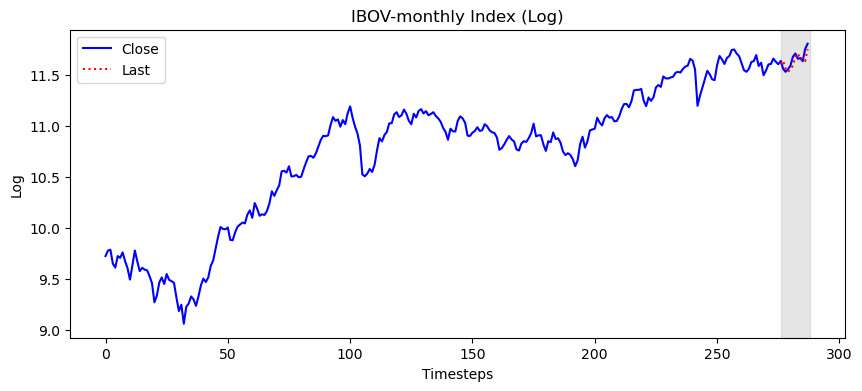

In [17]:
#===============================================================================================================================
# BASELINES: LOG - PLOT - close, last, mean
#===============================================================================================================================
fig, (ax3) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 4))

plt.title(seriesId+' Index (Log)', fontsize=12)
ax3.plot(dfln['CloseLn'], 'b-', label='Close')
ax3.plot(dfln.loc[testini:,'pred_LastLn'], 'r:', label='Last')
#ax3.plot(dfln.loc[testini:,'pred_MeanLn'], 'k-', label='Mean')
ax3.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax3.legend(loc=2)
ax3.set_xlabel('Timesteps')
ax3.set_ylabel('Log')

Text(0, 0.5, 'Log')

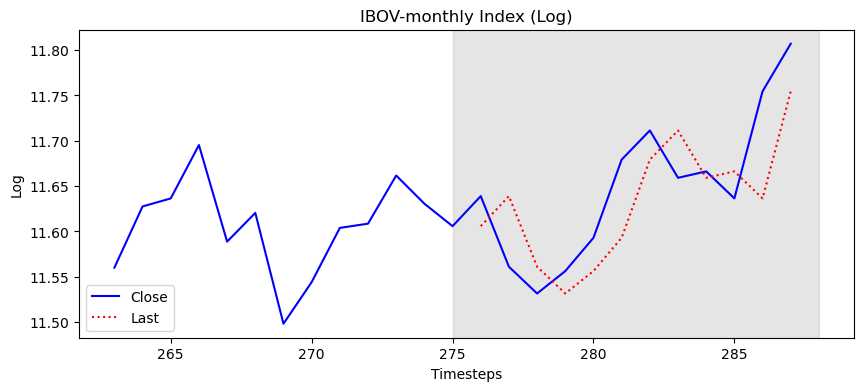

In [18]:
#===============================================================================================================================
# BASELINES: LOG - Plot (zoom) - close, last, mean
#===============================================================================================================================
fig, (ax3) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 4))

plt.title(seriesId+' Index (Log)', fontsize=12)
ax3.plot(dfln.loc[trainfin-testlen:,'CloseLn'    ], 'b-', label='Close')
ax3.plot(dfln.loc[testini:  ,'pred_LastLn'], 'r:', label='Last')
#ax3.plot(dfln.loc[testini:  ,'pred_MeanLn'], 'k-', label='Mean')
ax3.axvspan(trainfin, totallen, color='#808080', alpha=0.2)
ax3.legend(loc=3)
ax3.set_xlabel('Timesteps')
ax3.set_ylabel('Log')


In [19]:
#===============================================================================================================================
# BASELINES: PRICES - RECOVER
#===============================================================================================================================
df['pred_Last'] = 0.0
df['pred_Mean'] = 0.0


pred_Last = rolling_forecast(dfln['Close'], trainfin, HORIZON, WINDOW, 'last')
pred_Mean = rolling_forecast(dfln['Close'], trainfin+1, HORIZON, WINDOW, 'mean')

df.loc[testini:,'pred_Last']= pred_Last
df.loc[testini:,'pred_Mean']= np.round(pred_Mean,2)

df[testini-1:]

,Date,Close,pred_Last,pred_Mean
275,2022-12-29,109734.60,0.00,0.00
276,2023-01-31,113430.54,109734.60,55666.44
277,2023-02-28,104931.93,113430.54,55874.98
278,2023-03-31,101882.20,104931.93,56051.44
279,2023-04-28,104431.63,101882.20,56215.71
280,2023-05-31,108335.07,104431.63,56387.91
281,2023-06-30,118087.00,108335.07,56572.78
282,2023-07-31,121942.98,118087.00,56790.91
283,2023-08-31,115741.81,121942.98,57021.13
284,2023-09-29,116565.17,115741.81,57227.89


In [20]:
#===============================================================================================================================
# BASELINES: PRICES - RECOVER - PERFORMANCE
#===============================================================================================================================
mse_Last = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Last'])
mse_Mean = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Mean'])

data_metrics = [['Last'  , "{:,}".format(round(mse_Last,))  , "{:,}".format(round(sqrt(mse_Last),1))] ,
                ['Mean'  , "{:,}".format(round(mse_Mean,))  , "{:,}".format(round(sqrt(mse_Mean),1))] ]

df_metrics   = pd.DataFrame(data_metrics, columns=['Price', 'MSE', 'RMSE'])
df_metrics

,Price,MSE,RMSE
0,Last,"43,832,846","6,620.6"
1,Mean,"3,470,811,963","58,913.6"


Text(0, 0.5, 'Prices')

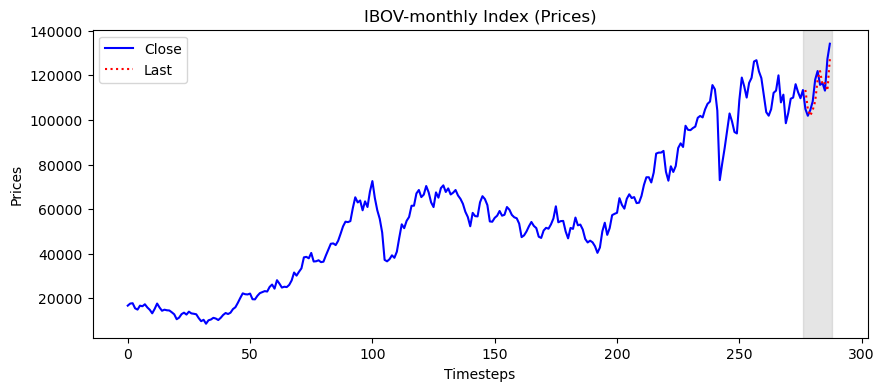

In [21]:
#===============================================================================================================================
# BASELINES: PRICES - RECOVER - PLOT
#===============================================================================================================================
fig, (ax3) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 4))

plt.title(seriesId+' Index (Prices)', fontsize=12)
ax3.plot(df['Close'], 'b-', label='Close')
ax3.plot(df.loc[testini+1:,'pred_Last'], 'r:', label='Last')
#ax3.plot(df.loc[testini+1:,'pred_Mean'], 'k-', label='Mean')
ax3.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax3.legend(loc=2)
ax3.set_xlabel('Timesteps')
ax3.set_ylabel('Prices')

Text(0, 0.5, 'Prices')

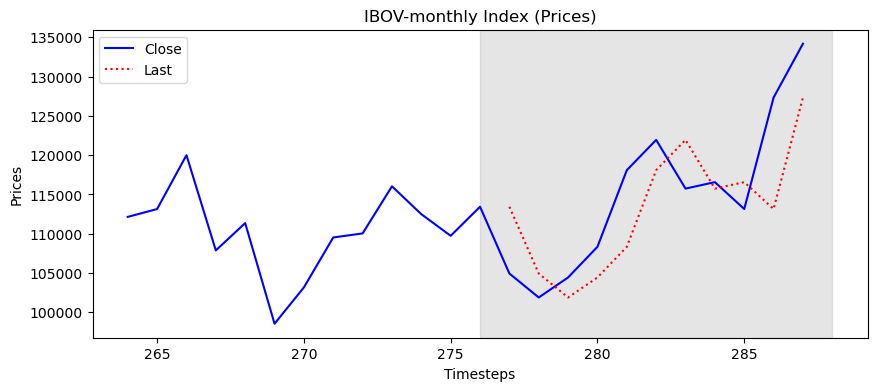

In [22]:
#===============================================================================================================================
# BASELINES: PRICES - RECOVER - PLOT (zoom)
#===============================================================================================================================
fig, (ax3) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 4))

plt.title(seriesId+' Index (Prices)', fontsize=12)
ax3.plot(df.loc[testini-testlen:,'Close'    ], 'b-', label='Close')
ax3.plot(df.loc[testini+1:  ,'pred_Last'], 'r:', label='Last')
#ax3.plot(df.loc[testini+1:  ,'pred_Mean'], 'k-', label='Mean')
ax3.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax3.legend(loc=2)
ax3.set_xlabel('Timesteps')
ax3.set_ylabel('Prices')

In [23]:
################################################################################################################################
# STATIONARITY
################################################################################################################################

#===============================================================================================================================
# STATIONARITY: LOG - ADF test
#===============================================================================================================================
ADF_Close = adfuller(dfln['CloseLn'])
print(f'ADF Statistic: {np.round(ADF_Close[0],3)}')
print(f'ADF p-value  : {np.round(ADF_Close[1],2)}')

#-------------------------------------------------------------------------------------------------------------------------------
# ADF Statistic: -0.922
# ADF p-value  : 0.78
#-------------------------------------------------------------------------------------------------------------------------------
# ***** NON-STATIONARY *****
#-------------------------------------------------------------------------------------------------------------------------------

ADF Statistic: -0.922
ADF p-value  : 0.78


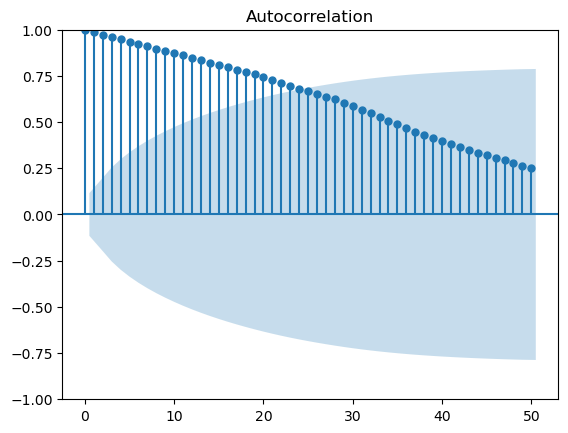

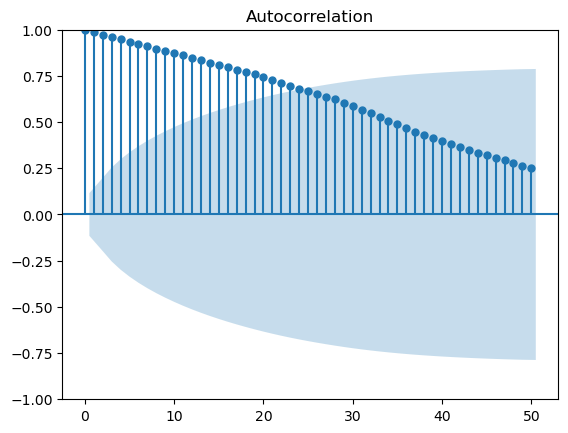

In [24]:
#===============================================================================================================================
# STATIONARITY: LOG - ACF plot
#===============================================================================================================================
plot_acf(dfln['CloseLn'], lags=50)

#-------------------------------------------------------------------------------------------------------------------------------
# Significant AC coefficients slowly decreasing after lag 0 
#-------------------------------------------------------------------------------------------------------------------------------
# ***** AUTOCORRELATION present ******
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# DATA STATIONARITY: LOG - ADF test + ACF plot
#===============================================================================================================================
#-------------------------------------------------------------------------------------------------------------------------------
# ***** NO RANDOM-WALK *****
#-------------------------------------------------------------------------------------------------------------------------------

In [25]:
#===============================================================================================================================
# STATIONARITY: LOG-DIFF - ADF test
#===============================================================================================================================
ADF_Close = adfuller(dfln['CloseLnDiff'])
print(f'ADF Statistic: {np.round(ADF_Close[0],3)}')
print(f'ADF p-value  : {np.round(ADF_Close[1],2)}')
#-------------------------------------------------------------------------------------------------------------------------------
# ADF Statistic: -15.122
# ADF p-value  : 0.0
# Null hypothesis rejected - No Unit Root
#-------------------------------------------------------------------------------------------------------------------------------
# ***** STATIONARY *****
#-------------------------------------------------------------------------------------------------------------------------------

ADF Statistic: -15.122
ADF p-value  : 0.0


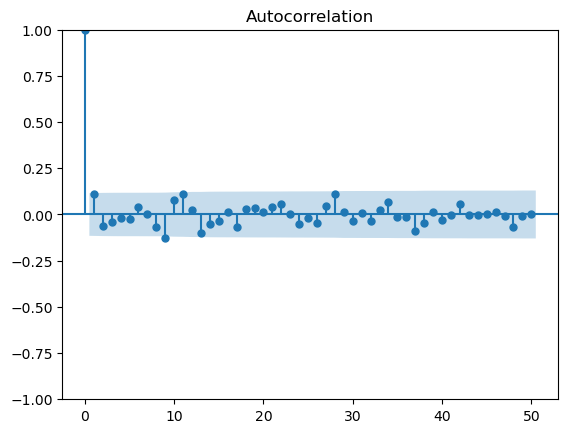

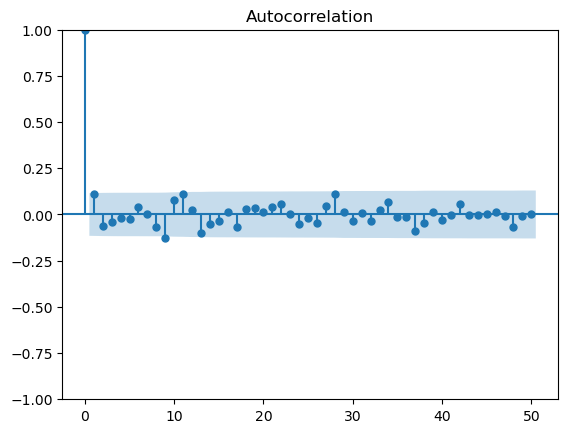

In [26]:
#===============================================================================================================================
# STATIONARITY: LOG-DIFF - ACF plot
#===============================================================================================================================
plot_acf(dfln['CloseLnDiff'], lags=50)
#-------------------------------------------------------------------------------------------------------------------------------
# No Significant AC coefficients after lag 0 
#-------------------------------------------------------------------------------------------------------------------------------
# ***** NO AUTOCORRELATION *****
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# DATA STATIONARITY: LOG-DIFF - ADF test + ACF plot
#===============================================================================================================================
#-------------------------------------------------------------------------------------------------------------------------------
# ***** RANDOM WALK *****
#-------------------------------------------------------------------------------------------------------------------------------

In [27]:
###############################################################################################################################
#
# MA - MOVING AVERAGE 
#
###############################################################################################################################

In [28]:
#===============================================================================================================================
# MA
#
# LOG: NON-STATIONARY (ADF Test & ACF Autocorrelation present)
# LOG-DIFF: STATIONARY (ADF Test & ACF Almost no Autocorrelation) => RANDOM WALK
#           ACF Coefficients don't become abruptly non-significant => No MOVING AVERAGE
#           ACF No Significant Coefficients after lag 0: 1,3,*6,10,*16,18
#===============================================================================================================================

#-------------------------------------------------------------------------------------------------------------------------------
# ***** LOG-RET: STATIONARY + NO AUTOCORRELATION => RANDOM WALK => NO MOVING AVERAGE *****
#-------------------------------------------------------------------------------------------------------------------------------

In [29]:
#===============================================================================================================================
# MA: LOG-RET - FORECAST
#===============================================================================================================================
pred_MALnDiff = rolling_forecast(dfln['CloseLnDiff'], testini, HORIZON, WINDOW, 'MA',(0,0,1))

                               SARIMAX Results                                
Dep. Variable:            CloseLnDiff   No. Observations:                  287
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 351.707
Date:                Mon, 02 Dec 2024   AIC                           -699.414
Time:                        17:49:23   BIC                           -692.095
Sample:                             0   HQIC                          -696.480
                                - 287                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1289      0.048      2.663      0.008       0.034       0.224
sigma2         0.0050      0.000     16.338      0.000       0.004       0.006
Ljung-Box (L1) (Q):                   0.05   Jarque-

In [30]:
#===============================================================================================================================
# MA: LOG-RET - EXCEL
#===============================================================================================================================
testln.loc[testini:,'pred_MALnDiff'] = 0
testln.loc[testini:,'pred_MALnDiff'] = pred_MALnDiff
testln.loc[testini:,'pred_MALnDiff'].to_excel('Data/Output/Rolling-Ln-Monthly-MALnDiff.xlsx')

In [31]:
#===============================================================================================================================
# MA: LOG-RET - PERFORMANCE
#===============================================================================================================================
mse_MA     = mean_squared_error(dfln.loc[testini:,'CloseLnDiff'], testln.loc[testini:,'pred_MALnDiff'])

data_metrics = [['MA'    , "{:,}".format(round(mse_MA,  6))  , "{:,}".format(round(sqrt(mse_MA)  ,6))] ]
 
df_metrics = pd.DataFrame(data_metrics, columns=['Log Diff', 'MSE', 'RMSE'])
df_metrics

,Log Diff,MSE,RMSE
0,MA,0.003166,0.056265


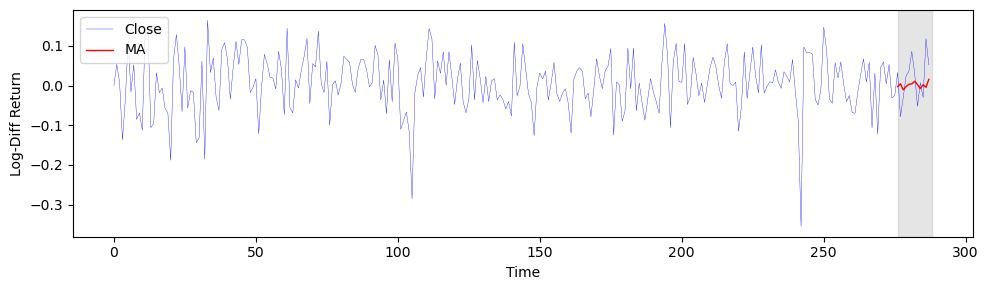

In [32]:
#===============================================================================================================================
# MA: LOG-RET - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(dfln.loc[:testini+1,'CloseLnDiff']        ,'b-', linewidth=0.25) 
ax.plot(dfln.loc[testini+1:totallen,'CloseLnDiff'],'b-', linewidth=0.25, label='Close')
ax.plot(testln.loc[:totallen,'pred_MALnDiff']     ,'r-', linewidth=1.0, label='MA')
ax.axvspan(testini,totallen, color='#808080', alpha=0.2)
ax.legend(loc=2)
#plt.xticks([ testini-testlen, testini],           ['2022'          , '2023'])
ax.set_xlabel('Time')
ax.set_ylabel('Log-Diff Return')
plt.tight_layout()


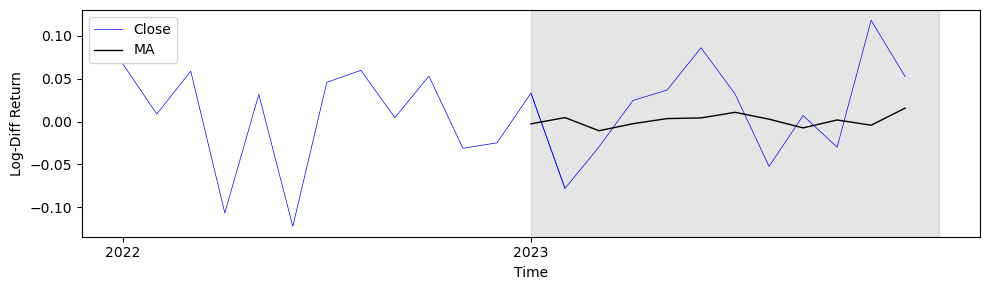

In [33]:
#===============================================================================================================================
# MA: LOG-RET - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(dfln.loc[testini-testlen:testini+1,'CloseLnDiff'],'b-', linewidth=0.5) 
ax.plot(dfln.loc[testini:totallen,'CloseLnDiff']         ,'b-', linewidth=0.5, label='Close')
ax.plot(testln.loc[testini:totallen,'pred_MALnDiff']     ,'k-', linewidth=1.0, label='MA')
ax.axvspan(testini,totallen, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks([ testini-testlen, testini],           ['2022'          , '2023'])
ax.set_xlabel('Time')
ax.set_ylabel('Log-Diff Return')
plt.tight_layout()


In [34]:
#===============================================================================================================================
# MA: LOG - RECOVER
#===============================================================================================================================
dfln['pred_MALn'] = 0.0
dfln.loc[testini:,'pred_MALn'] = dfln.shift(periods=1).loc[testini:, 'CloseLn'] + testln.loc[testini:,'pred_MALnDiff']
dfln.loc[:,'pred_MALn'].to_excel('Data/Output/Rolling-Ln-Monthly-MALn.xlsx')
dfln[testini-1:]


,Date,Close,CloseLn,CloseLnDiff,pred_LastLn,pred_MeanLn,pred_MALn
275,2022-12-29,109734.60,11.605820,-0.024764,0.000000,0.000000,0.000000
276,2023-01-31,113430.54,11.638946,0.033126,11.605820,10.732902,11.603222
277,2023-02-28,104931.93,11.561067,-0.077879,11.638946,10.736173,11.643631
278,2023-03-31,101882.20,11.531573,-0.029495,11.561067,10.739140,11.550445
279,2023-04-28,104431.63,11.556288,0.024715,11.531573,10.741981,11.529132
280,2023-05-31,108335.07,11.592984,0.036696,11.556288,10.744889,11.559815
281,2023-06-30,118087.00,11.679177,0.086193,11.592984,10.747907,11.597314
282,2023-07-31,121942.98,11.711309,0.032132,11.679177,10.751209,11.690011
283,2023-08-31,115741.81,11.659117,-0.052192,11.711309,10.754602,11.714143
284,2023-09-29,116565.17,11.666206,0.007089,11.659117,10.757787,11.651787


In [35]:
#===============================================================================================================================
# MA: LOG - PERFORMANCE
#===============================================================================================================================
mse_Last   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_LastLn'])
mse_Mean   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MeanLn'])
mse_MA     = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MALn'  ])

data_metrics = [['Last'  , "{:,}".format(round(mse_Last,6))  , "{:,}".format(round(sqrt(mse_Last),6))] ,
                ['Mean'  , "{:,}".format(round(mse_Mean,6))  , "{:,}".format(round(sqrt(mse_Mean),6))] ,
                ['MA'    , "{:,}".format(round(mse_MA,  6))  , "{:,}".format(round(sqrt(mse_MA)  ,6))] ]

df_metrics = pd.DataFrame(data_metrics, columns=['Log', 'MSE', 'RMSE'])
df_metrics

,Log,MSE,RMSE
0,Last,0.003235,0.056875
1,Mean,0.814346,0.902411
2,MA,0.003166,0.056265


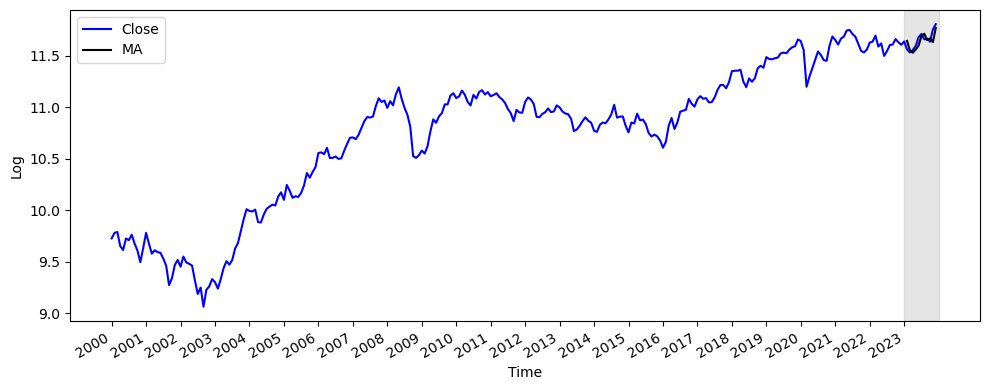

In [36]:
#===============================================================================================================================
# MA: LOG - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dfln['CloseLn'], 'b-', label='Close')    
#ax.plot(dfln.loc[testini+1:,'pred_LastLn'], 'r-' , label='Last')
#ax.plot(dfln.loc[testini+1:,'pred_MeanLn'], 'm-.', label='Mean')
ax.plot(dfln.loc[testini+1:,'pred_MALn']  , 'k-' , label='MA')   
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
#ax.set_xlim(testini, totallen)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()


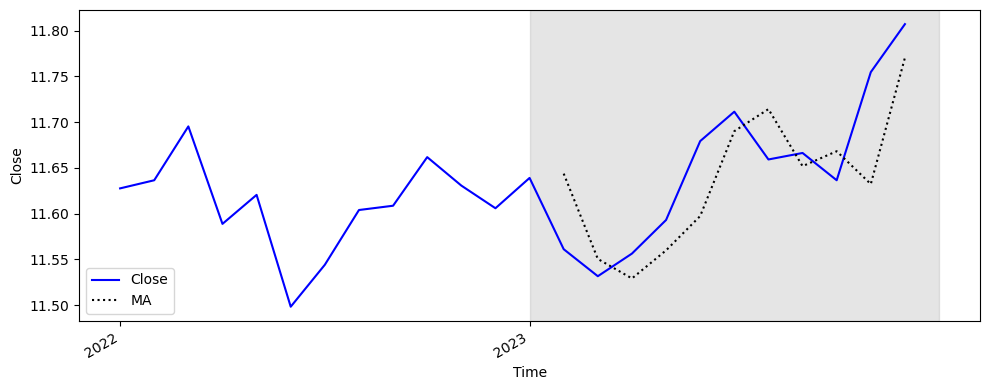

In [37]:
#===============================================================================================================================
# MA: LOG - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dfln.loc[testini-testlen:,'CloseLn'] , 'b-' , label='Close')    
#ax.plot(dfln.loc[testini+1:,'pred_LastLn']  , 'r-' , label='Last')
#ax.plot(dfln.loc[testini+1:,'pred_MeanLn']  , 'y-.', label='Mean')
ax.plot(dfln.loc[testini+1:,'pred_MALn']    , 'k:' , label='MA')   

ax.legend(loc=3)
ax.set_xlabel('Time')
ax.set_ylabel('Close')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
#ax.set_xlim(testini, totallen)
plt.xticks([testini-testlen, testini],           ['2022'          , '2023'])
fig.autofmt_xdate()
plt.tight_layout()


In [38]:
#===============================================================================================================================
# MA: PRICE - RECOVER
#===============================================================================================================================
df['pred_MA'] = 0.0
df.loc[testini:,'pred_MA']= np.round(np.exp(dfln.loc[testini:,'pred_MALn']),2)
#df.loc[:,'pred_MA'].to_excel('Data/Output/Rolling-Ln-Monthly-MA.xlsx')
df[testini-1:]

,Date,Close,pred_Last,pred_Mean,pred_MA
275,2022-12-29,109734.60,0.00,0.00,0.00
276,2023-01-31,113430.54,109734.60,55666.44,109449.87
277,2023-02-28,104931.93,113430.54,55874.98,113963.19
278,2023-03-31,101882.20,104931.93,56051.44,103823.20
279,2023-04-28,104431.63,101882.20,56215.71,101633.90
280,2023-05-31,108335.07,104431.63,56387.91,104800.63
281,2023-06-30,118087.00,108335.07,56572.78,108805.12
282,2023-07-31,121942.98,118087.00,56790.91,119373.31
283,2023-08-31,115741.81,121942.98,57021.13,122289.06
284,2023-09-29,116565.17,115741.81,57227.89,114896.48


In [39]:
#===============================================================================================================================
# MA: PRICE - PERFORMANCE
#===============================================================================================================================
mse_Last = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Last'])
mse_Mean = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Mean'])
mse_MA   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_MA'  ])

data_metrics = [['Last'  , "{:,}".format(round(mse_Last,))  , "{:,}".format(round(sqrt(mse_Last),1))] ,
                ['MA'    , "{:,}".format(round(mse_MA,  ))  , "{:,}".format(round(sqrt(mse_MA  ),1))] ]

df_metrics   = pd.DataFrame(data_metrics, columns=['Price', 'MSE', 'RMSE'])
df_metrics

,Price,MSE,RMSE
0,Last,"43,832,846","6,620.6"
1,MA,"42,620,739","6,528.5"


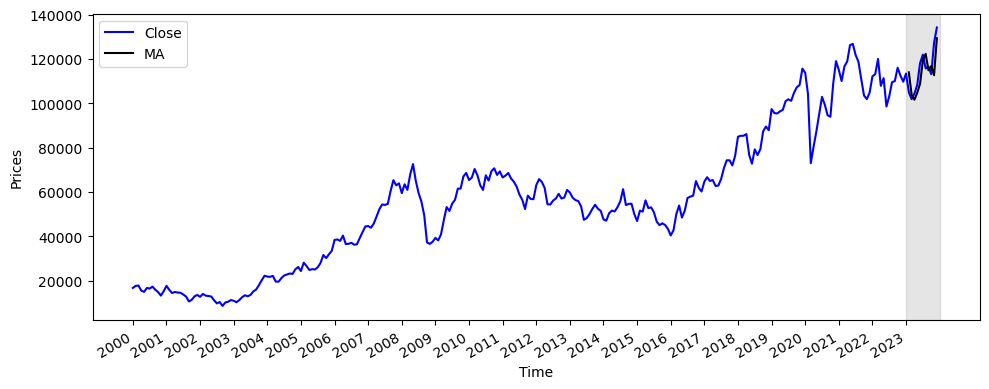

In [40]:
#===============================================================================================================================
# MA: PRICES - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['Close'], 'b-', label='Close')    
#ax.plot(df.loc[testini+1:,'pred_Last'], 'r-' , label='Last')
#ax.plot(df.loc[testini+1:,'pred_Mean'], 'm-.', label='Mean')
ax.plot(df.loc[testini+1:,'pred_MA']  , 'k-' , label='MA')   
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Prices')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
#ax.set_xlim(testini, totallen)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

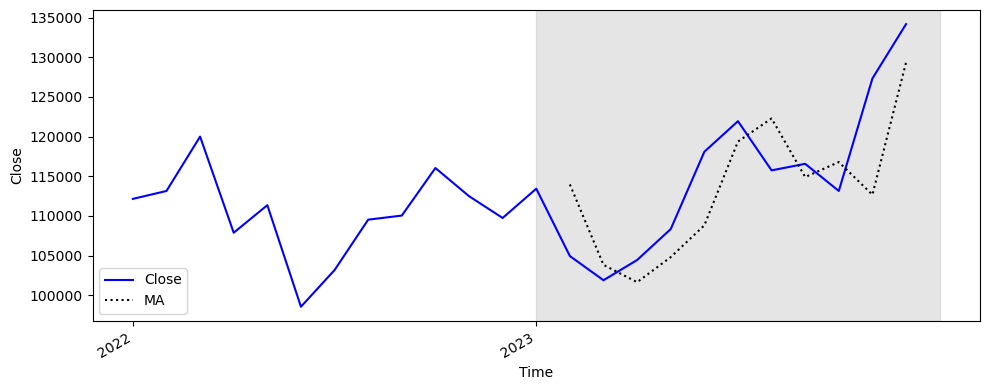

In [41]:
#===============================================================================================================================
# MA: PRICES - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.loc[testini-testlen:,'Close'] , 'b-' , label='Close')    
#ax.plot(df.loc[testini+1:,'pred_Last']  , 'r-' , label='Last')
#ax.plot(df.loc[testini+1:,'pred_Mean']  , 'y-.', label='Mean')
ax.plot(df.loc[testini+1:,'pred_MA']    , 'k:' , label='MA')   

ax.legend(loc=3)
ax.set_xlabel('Time')
ax.set_ylabel('Close')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
#ax.set_xlim(testini, totallen)
plt.xticks([testini-testlen, testini],           ['2022'          , '2023'])
fig.autofmt_xdate()
plt.tight_layout()

In [42]:
df.loc[testini:,['Date','pred_Last']].to_csv('Data/Output/Rolling-Ln-Monthly-Last.csv')
df.loc[testini:,['Date','pred_MA'  ]].to_csv('Data/Output/Rolling-Ln-Monthly-MA.csv'  )
#df.loc[testini:,['Date','pred_MA'  ]].to_excel('Data/Output/Rolling-Ln-Monthly-MA.xlsx')

In [43]:
################################################################################################################################
#
# AUTOREGRESSIVE (AR)
#
################################################################################################################################

In [44]:
#===============================================================================================================================
# AR
#
# LOG:      ADF Test + ACF Coefficients slowly decaying => AUTOCORRELATION present => NON-STATIONARY
# LOG-RET : ADF Test + ACF Almost no Autocorrelation => STATIONARY  => RANDOM WALK
#           ACF Coefficients don't become abruptly non-significant  => No MOVING AVERAGE
#           PACF Coefficients don't become abruptly non-significant => No AUTOREGRESSIVE
#===============================================================================================================================

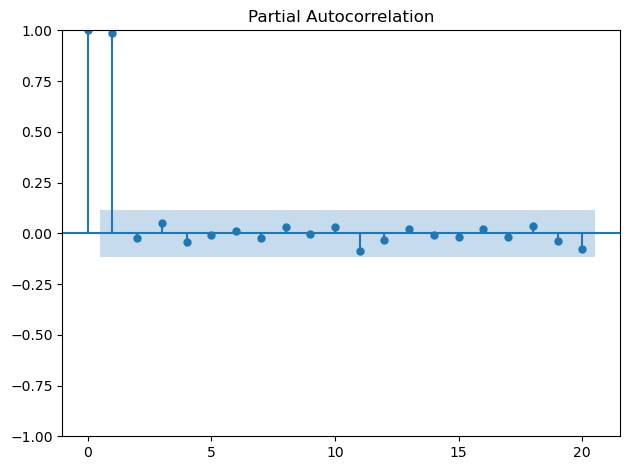

In [45]:
#===============================================================================================================================
# AR: LOG - PACF - AR(p) order
#===============================================================================================================================
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(dfln['CloseLn'], lags=20)
plt.tight_layout()

#-------------------------------------------------------------------------------------------------------------------------------
# PACF - order 1 AR(1)
#-------------------------------------------------------------------------------------------------------------------------------
# ****** AR(1) process ******
#-------------------------------------------------------------------------------------------------------------------------------

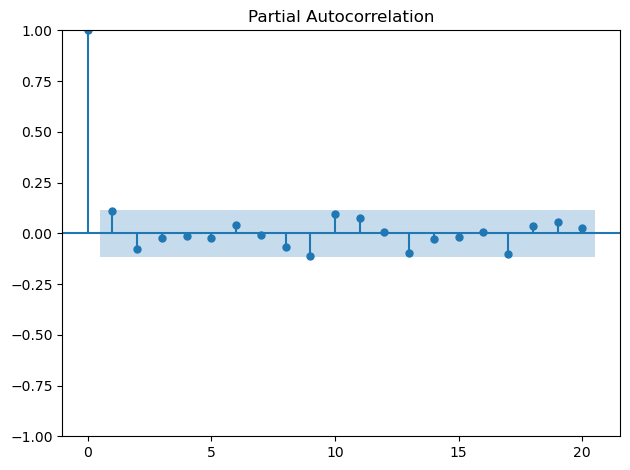

In [46]:
#===============================================================================================================================
# AR: LOG-RET - PACF - AR(p) order
#===============================================================================================================================
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(dfln['CloseLnDiff'], lags=20)
plt.tight_layout()

#-------------------------------------------------------------------------------------------------------------------------------
# PACF - NO AUTOCORRELATION
#-------------------------------------------------------------------------------------------------------------------------------
# ****** AR(0) process ******
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# AR: LOG-RET - ADF Test + PACF Plot
#===============================================================================================================================
#-------------------------------------------------------------------------------------------------------------------------------
# ****** RANDOM WALK ******
#-------------------------------------------------------------------------------------------------------------------------------

In [47]:
#===============================================================================================================================
# AR: LOG-RET - FORECAST
#===============================================================================================================================
pred_ARLnDiff = rolling_forecast(dfln['CloseLnDiff'], testini, HORIZON, WINDOW, 'AR', (1,0,0))

                               SARIMAX Results                                
Dep. Variable:            CloseLnDiff   No. Observations:                  287
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 351.457
Date:                Mon, 02 Dec 2024   AIC                           -698.915
Time:                        17:49:26   BIC                           -691.596
Sample:                             0   HQIC                          -695.981
                                - 287                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1148      0.049      2.362      0.018       0.020       0.210
sigma2         0.0051      0.000     16.154      0.000       0.004       0.006
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [48]:
#===============================================================================================================================
# AR: LOG-RET - STORE PRED, SAVE EXCEL
#===============================================================================================================================
testln.loc[testini:,'pred_ARLnDiff'] = 0
testln.loc[testini:,'pred_ARLnDiff'] = pred_ARLnDiff
testln.loc[testini:,'pred_ARLnDiff'].to_excel('Data/Output/Rolling-Ln-Monthly-ARLnDiff.xlsx')

In [49]:
#===============================================================================================================================
# AR: LOG-RET - PERFORMANCE
#===============================================================================================================================
mse_MA     = mean_squared_error(dfln.loc[testini:,'CloseLnDiff'], testln.loc[testini:,'pred_MALnDiff'  ])
mse_AR     = mean_squared_error(dfln.loc[testini:,'CloseLnDiff'], testln.loc[testini:,'pred_ARLnDiff'  ])

data_metrics = [['MA'    , "{:,}".format(round(mse_MA  ,6))  , "{:,}".format(round(sqrt(mse_MA)  ,6))] ,
                ['AR'    , "{:,}".format(round(mse_AR  ,6))  , "{:,}".format(round(sqrt(mse_AR)  ,6))] ]
 
df_metrics = pd.DataFrame(data_metrics, columns=['Log Diff', 'MSE', 'RMSE'])

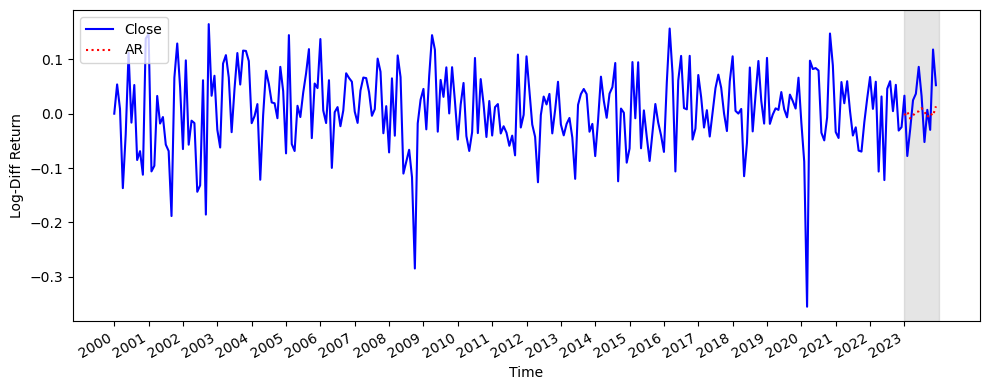

In [50]:
#===============================================================================================================================
# AR: LOG-RET - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dfln['CloseLnDiff']    , 'b-', label='Close')    
#ax.plot(testln['pred_MALnDiff'], 'g-', label='MA')   
ax.plot(testln['pred_ARLnDiff'], 'r:', label='AR')   
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log-Diff Return')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

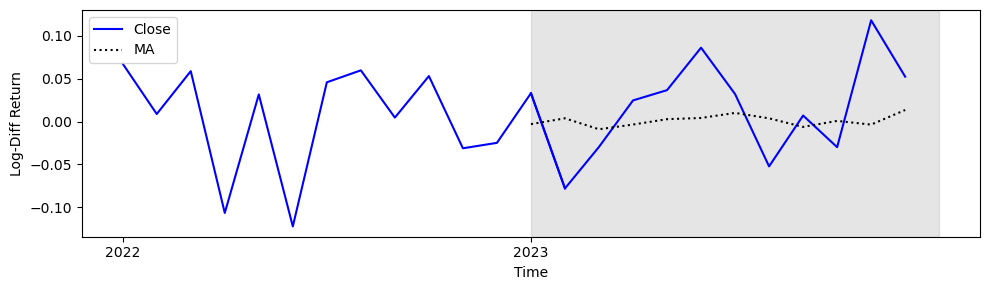

In [51]:
#===============================================================================================================================
# AR: LOG-RET - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(dfln.loc[testini-testlen:testini+1,'CloseLnDiff'],    'b-') 
ax.plot(dfln.loc[testini:totallen,'CloseLnDiff'],    'b-', label='Close')
#ax.plot(testln.loc[testini:totallen,'pred_MALnDiff'],  'm-.', label='MA')
ax.plot(testln.loc[testini:totallen,'pred_ARLnDiff'],  'k:', label='MA')
ax.axvspan(testini,testini+testlen, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks([testini-testlen, testini],           ['2022'          , '2023'])
ax.set_xlabel('Time')
ax.set_ylabel('Log-Diff Return')
plt.tight_layout()

In [52]:
#===============================================================================================================================
# AR: LOG - RECOVER
#===============================================================================================================================
dfln['pred_ARLn'] = 0.0
dfln.loc[testini:,'pred_ARLn'] = dfln.shift(periods=1).loc[testini:, 'CloseLn'] + testln.loc[testini:,'pred_ARLnDiff']
dfln.loc[testini:,'pred_ARLn'].to_excel('Data/Output/Rolling-Ln-Monthly-ARLn.xlsx')
dfln[testini-1:]


,Date,Close,CloseLn,CloseLnDiff,pred_LastLn,pred_MeanLn,pred_MALn,pred_ARLn
275,2022-12-29,109734.60,11.605820,-0.024764,0.000000,0.000000,0.000000,0.000000
276,2023-01-31,113430.54,11.638946,0.033126,11.605820,10.732902,11.603222,11.602919
277,2023-02-28,104931.93,11.561067,-0.077879,11.638946,10.736173,11.643631,11.642805
278,2023-03-31,101882.20,11.531573,-0.029495,11.561067,10.739140,11.550445,11.552141
279,2023-04-28,104431.63,11.556288,0.024715,11.531573,10.741981,11.529132,11.528159
280,2023-05-31,108335.07,11.592984,0.036696,11.556288,10.744889,11.559815,11.559134
281,2023-06-30,118087.00,11.679177,0.086193,11.592984,10.747907,11.597314,11.597231
282,2023-07-31,121942.98,11.711309,0.032132,11.679177,10.751209,11.690011,11.689332
283,2023-08-31,115741.81,11.659117,-0.052192,11.711309,10.754602,11.714143,11.715136
284,2023-09-29,116565.17,11.666206,0.007089,11.659117,10.757787,11.651787,11.652965


In [53]:
#===============================================================================================================================
# AR: LOG - PERFORMANCE
#===============================================================================================================================
mse_Last   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_LastLn'])
mse_Mean   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MeanLn'])
mse_MA     = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MALn'  ])
mse_AR     = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_ARLn'  ])

data_metrics = [['Last'  , "{:,}".format(round(mse_Last,6 ))  , "{:,}".format(round(sqrt(mse_Last),6))] ,
                ['Mean'  , "{:,}".format(round(mse_Mean,6 ))  , "{:,}".format(round(sqrt(mse_Mean),6))] ,
                ['MA'    , "{:,}".format(round(mse_MA  ,6 ))  , "{:,}".format(round(sqrt(mse_MA)  ,6))] ,
                ['AR'    , "{:,}".format(round(mse_AR  ,6 ))  , "{:,}".format(round(sqrt(mse_AR)  ,6))] ]

df_metrics = pd.DataFrame(data_metrics, columns=['Log', 'MSE', 'RMSE'])

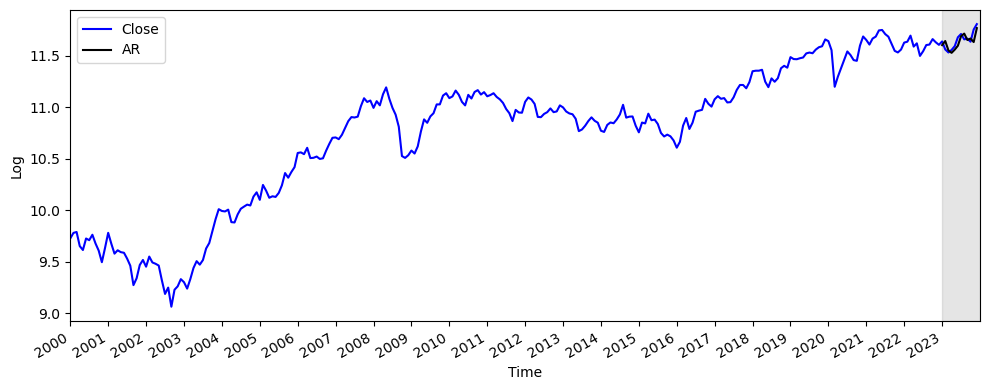

In [54]:
#===============================================================================================================================
# AR: LOG - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dfln['CloseLn']                 , 'b-', label='Close')    
#ax.plot(dfln.loc[testini:,'pred_LastLn'], 'r-' , label='Last')
#ax.plot(dfln.loc[testini:,'pred_MeanLn'], 'm-.', label='Mean')
#ax.plot(dfln.loc[testini:,'pred_MALn']  , 'y-' , label='MA')   
ax.plot(dfln.loc[testini:,'pred_ARLn']  , 'k-' , label='AR')   
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini, totallen)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

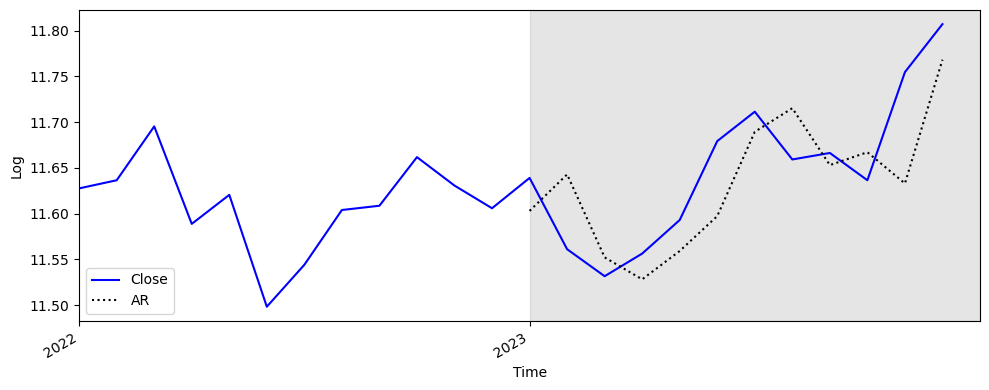

In [55]:
#===============================================================================================================================
# AR: LOG - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dfln.loc[testini-testlen:,'CloseLn'], 'b-' , label='Close')
#ax.plot(dfln.loc[testini:,'pred_LastLn']    , 'r-' , label='Last')
#ax.plot(dfln.loc[testini:,'pred_MeanLn']    , 'm-.', label='Mean')
#ax.plot(dfln.loc[testini:,'pred_MALn']      , 'y:' , label='MA')
ax.plot(dfln.loc[testini:,'pred_ARLn']      , 'k:' , label='AR')

ax.legend(loc=3)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini, totallen)
plt.xticks([testini-testlen, testini],           ['2022'          , '2023'])
fig.autofmt_xdate()
plt.tight_layout()


In [56]:
#===============================================================================================================================
# AR: PRICES - RECOVER
#===============================================================================================================================
df['pred_AR'] = 0.0
df.loc[testini:,'pred_AR']= np.round(np.exp(dfln.loc[testini:,'pred_ARLn']),2)
df[testini-1:]

,Date,Close,pred_Last,pred_Mean,pred_MA,pred_AR
275,2022-12-29,109734.60,0.00,0.00,0.00,0.00
276,2023-01-31,113430.54,109734.60,55666.44,109449.87,109416.77
277,2023-02-28,104931.93,113430.54,55874.98,113963.19,113869.16
278,2023-03-31,101882.20,104931.93,56051.44,103823.20,103999.42
279,2023-04-28,104431.63,101882.20,56215.71,101633.90,101535.02
280,2023-05-31,108335.07,104431.63,56387.91,104800.63,104729.28
281,2023-06-30,118087.00,108335.07,56572.78,108805.12,108796.16
282,2023-07-31,121942.98,118087.00,56790.91,119373.31,119292.29
283,2023-08-31,115741.81,121942.98,57021.13,122289.06,122410.63
284,2023-09-29,116565.17,115741.81,57227.89,114896.48,115031.89


In [57]:
#===============================================================================================================================
# AR: PRICES - PERFORMANCE
#===============================================================================================================================
mse_Last = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Last'])
mse_Mean = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Mean'])
mse_MA   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_MA'  ])
mse_AR   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_AR'  ])

data_metrics = [['Last'  , "{:,}".format(round(mse_Last,))  , "{:,}".format(round(sqrt(mse_Last),1))] ,
                ['MA'    , "{:,}".format(round(mse_MA,  ))  , "{:,}".format(round(sqrt(mse_MA  ),1))] ,
                ['AR'    , "{:,}".format(round(mse_AR,  ))  , "{:,}".format(round(sqrt(mse_AR  ),1))] ]

df_metrics   = pd.DataFrame(data_metrics, columns=['Price', 'MSE', 'RMSE'])
df_metrics

,Price,MSE,RMSE
0,Last,"43,832,846","6,620.6"
1,MA,"42,620,739","6,528.5"
2,AR,"42,768,145","6,539.7"


In [58]:
################################################################################################################################
#
# ARMA
#
################################################################################################################################

In [59]:
#===============================================================================================================================
# ARMA: OPTIMIZE Function - AIC (Akaike Information Criterion)
#===============================================================================================================================
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
             continue
        
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [60]:
#===============================================================================================================================
# ARMA: TRAIN SET
#===============================================================================================================================
train = df.Close[:trainfin+1]
trainLn = dfln.CloseLn[:trainfin+1]
trainLnDiff = dfln.CloseLnDiff[:trainfin+1]

In [61]:
#===============================================================================================================================
# ARMA: PARAMETERS ps, qs
#===============================================================================================================================
from itertools import product
ps = range(0, 4, 1)    
qs = range(0, 4, 1)     

order_list = list(product(ps, qs))
len(order_list)

16

In [62]:
#===============================================================================================================================
# ARMA: Optimize_ARMA (AIC)
#===============================================================================================================================
result_df = optimize_ARMA(trainLnDiff, order_list) 
result_df

C:\Users\55119\AppData\Local\Temp\ipykernel_1812\3737658289.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\55119\anaconda3\Lib\site-packa

,"(p,q)",AIC
0,"(2, 3)",-669.134330
1,"(0, 1)",-668.731641
2,"(1, 0)",-668.227207
3,"(2, 0)",-667.534976
4,"(0, 2)",-667.347519
5,"(1, 1)",-667.122351
6,"(0, 0)",-666.429881
7,"(0, 3)",-665.613792
8,"(3, 0)",-665.574779
9,"(2, 1)",-665.572637


In [63]:
#===============================================================================================================================
# ARMA: LOG-RET - FORECAST
#===============================================================================================================================
pred_ARMALnDiff = rolling_forecast(dfln['CloseLnDiff'], testini, HORIZON, WINDOW, 'ARMA',(0,0,1))

                               SARIMAX Results                                
Dep. Variable:            CloseLnDiff   No. Observations:                  287
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 351.707
Date:                Mon, 02 Dec 2024   AIC                           -699.414
Time:                        17:49:29   BIC                           -692.095
Sample:                             0   HQIC                          -696.480
                                - 287                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1289      0.048      2.663      0.008       0.034       0.224
sigma2         0.0050      0.000     16.338      0.000       0.004       0.006
Ljung-Box (L1) (Q):                   0.05   Jarque-

In [64]:
#===============================================================================================================================
# ARMA: LOG-RET - EXCEL
#===============================================================================================================================
testln.loc[testini:,'pred_ARMALnDiff'] = 0
testln.loc[testini:,'pred_ARMALnDiff'] = pred_ARMALnDiff
testln.loc[testini:,'pred_ARMALnDiff'].to_excel('Data/Output/Rolling-Ln-Monthly-ARMALnDiff.xlsx')

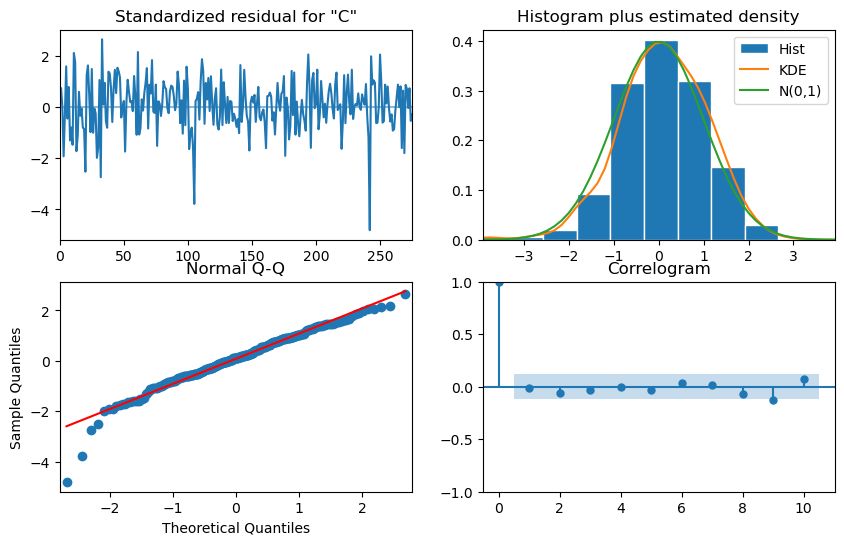

In [65]:
#===============================================================================================================================
# ARMA: DIAGNOSTICS
#===============================================================================================================================
model = SARIMAX(trainLnDiff, order=(0,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10,6))
residuals = model_fit.resid 

#-------------------------------------------------------------------------------------------------------------------------------
#
# Residuals: No Trend, but Variance is not constant (discrepancy to white noise).
# Residuals: Distribution fairly close to a Normal distribution.
# Q-Q plot: Line fairly straight => Residuals’ distribution close to a Normal distribution.
# Correlogram: No significant Coefficients after lag 0 => White Noise.
#
#-------------------------------------------------------------------------------------------------------------------------------

In [66]:
#===============================================================================================================================
# ARMA: LOG - RESIDUALS - LJUNG-BOX test
#===============================================================================================================================
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

sm.stats.acorr_ljungbox(residuals, lags=[11], return_df=True)

#-------------------------------------------------------------------------------------------------------------------------------
# LJUNG-BOX test: pvalue > 0.05 => Residuals NOT CORRELATED
#-------------------------------------------------------------------------------------------------------------------------------
# ***** WHITE NOISE => Model can be used to FORECAST *****
#-------------------------------------------------------------------------------------------------------------------------------

,lb_stat,lb_pvalue
11,12.163611,0.351472


In [67]:
#===============================================================================================================================
# ARMA: LOG-DIFF - PERFORMANCE
#===============================================================================================================================
mse_MA     = mean_squared_error(dfln.loc[testini:,'CloseLnDiff'], testln.loc[testini:,'pred_MALnDiff'  ])
mse_AR     = mean_squared_error(dfln.loc[testini:,'CloseLnDiff'], testln.loc[testini:,'pred_ARLnDiff'  ])
mse_ARMA   = mean_squared_error(dfln.loc[testini:,'CloseLnDiff'], testln.loc[testini:,'pred_ARMALnDiff'])

data_metrics = [['MA'    , "{:,}".format(round(mse_MA  ,6))  , "{:,}".format(round(sqrt(mse_MA)  ,6))] ,
                ['AR'    , "{:,}".format(round(mse_AR  ,6))  , "{:,}".format(round(sqrt(mse_AR)  ,6))] ,
                ['ARMA'  , "{:,}".format(round(mse_ARMA,6))  , "{:,}".format(round(sqrt(mse_ARMA),6))] ]
 
df_metrics = pd.DataFrame(data_metrics, columns=['Log Diff', 'MSE', 'RMSE'])

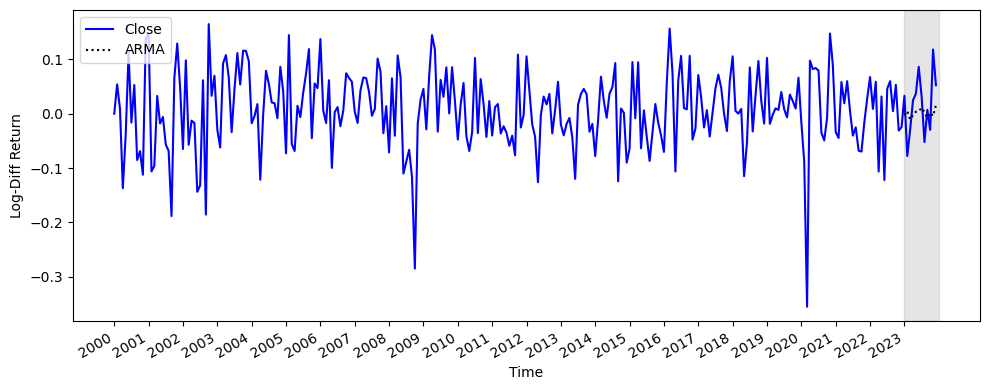

In [68]:
#===============================================================================================================================
# ARMA: LOG-DIFF - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dfln['CloseLnDiff']      , 'b-' , label='Close')
#ax.plot(testln['pred_MALnDiff']  , 'g-' , label='MA')
#ax.plot(testln['pred_ARLnDiff']  , 'y-.', label='AR')
ax.plot(testln['pred_ARMALnDiff'], 'k:' , label='ARMA')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log-Diff Return')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

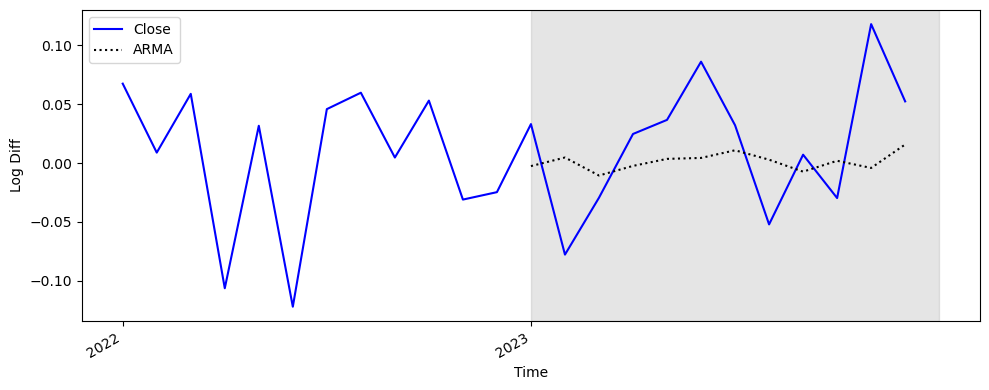

In [69]:
#===============================================================================================================================
# ARMA: LOG-DIFF - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dfln.loc[testini-testlen:,'CloseLnDiff'], 'b-' , label='Close')
#ax.plot(testln.loc[-testlen:,'pred_MALnDiff']   , 'g-' , label='MA')
#ax.plot(testln.loc[-testlen:,'pred_ARLnDiff']   , 'y-.', label='AR')
ax.plot(testln.loc[-testlen:,'pred_ARMALnDiff'] , 'k:' , label='ARMA')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log Diff')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
plt.xticks(np.arange(testini-testlen, totallen, testlen), [2022, 2023])
fig.autofmt_xdate()
plt.tight_layout()

In [70]:
#===============================================================================================================================
# ARMA: LOG - RECOVER
#===============================================================================================================================
dfln['pred_ARMALn'] = 0.0
dfln.loc[testini:,'pred_ARMALn'] = dfln.shift(periods=1).loc[testini:, 'CloseLn'] + testln.loc[testini:,'pred_ARMALnDiff']
dfln[testini-1:]

,Date,Close,CloseLn,CloseLnDiff,pred_LastLn,pred_MeanLn,pred_MALn,pred_ARLn,pred_ARMALn
275,2022-12-29,109734.60,11.605820,-0.024764,0.000000,0.000000,0.000000,0.000000,0.000000
276,2023-01-31,113430.54,11.638946,0.033126,11.605820,10.732902,11.603222,11.602919,11.603222
277,2023-02-28,104931.93,11.561067,-0.077879,11.638946,10.736173,11.643631,11.642805,11.643631
278,2023-03-31,101882.20,11.531573,-0.029495,11.561067,10.739140,11.550445,11.552141,11.550445
279,2023-04-28,104431.63,11.556288,0.024715,11.531573,10.741981,11.529132,11.528159,11.529132
280,2023-05-31,108335.07,11.592984,0.036696,11.556288,10.744889,11.559815,11.559134,11.559815
281,2023-06-30,118087.00,11.679177,0.086193,11.592984,10.747907,11.597314,11.597231,11.597314
282,2023-07-31,121942.98,11.711309,0.032132,11.679177,10.751209,11.690011,11.689332,11.690011
283,2023-08-31,115741.81,11.659117,-0.052192,11.711309,10.754602,11.714143,11.715136,11.714143
284,2023-09-29,116565.17,11.666206,0.007089,11.659117,10.757787,11.651787,11.652965,11.651787


In [71]:
#===============================================================================================================================
# ARMA: LOG - PERFORMANCE
#===============================================================================================================================
mse_Last   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_LastLn'])
mse_Mean   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MeanLn'])
mse_MA     = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MALn'  ])
mse_AR     = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_ARLn'  ])
mse_ARMA   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_ARMALn'])

data_metrics = [['Last'  , "{:,}".format(round(mse_Last,8 ))  , "{:,}".format(round(sqrt(mse_Last),6))] ,
                ['Mean'  , "{:,}".format(round(mse_Mean,8))  , "{:,}".format(round(sqrt(mse_Mean) ,6))] ,
                ['MA'    , "{:,}".format(round(mse_MA  ,8 ))  , "{:,}".format(round(sqrt(mse_MA)  ,6))] ,
                ['AR'    , "{:,}".format(round(mse_AR  ,8 ))  , "{:,}".format(round(sqrt(mse_AR)  ,6))] ,
                ['ARMA'  , "{:,}".format(round(mse_ARMA,8 ))  , "{:,}".format(round(sqrt(mse_ARMA),6))] ]

df_metrics = pd.DataFrame(data_metrics, columns=['Log', 'MSE', 'RMSE'])

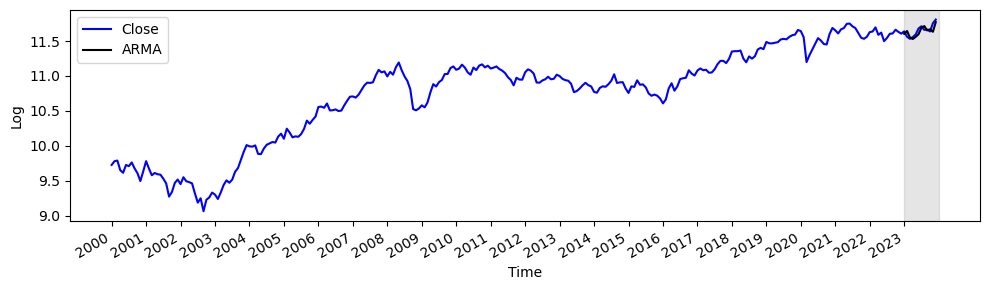

In [72]:
#===============================================================================================================================
# ARMA: LOG - Plot
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(dfln['CloseLn'], 'b-', label='Close')    
#ax.plot(dfln.loc[testini:,'pred_LastLn'], 'r-' , label='Last')
#ax.plot(dfln.loc[testini:,'pred_MeanLn'], 'm-.', label='Mean')
#ax.plot(dfln.loc[testini:,'pred_MALn']  , 'y-' , label='MA')   
#ax.plot(dfln.loc[testini:,'pred_ARLn']  , 'g-.', label='AR')   
ax.plot(dfln.loc[testini:,'pred_ARMALn'], 'k-' , label='ARMA')   

ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
#ax.set_xlim(testini, totallen)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

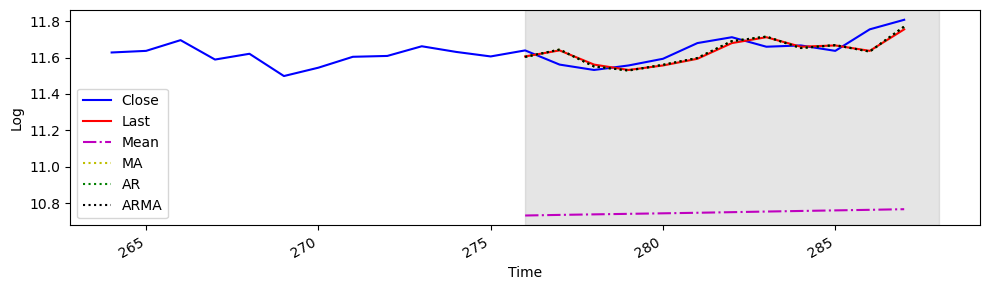

In [73]:
#===============================================================================================================================
# ARMA: LOG - Plot (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(dfln.loc[testini-testlen:,'CloseLn']   , 'b-', label='Close')
ax.plot(dfln.loc[testini:,'pred_LastLn'] , 'r-' , label='Last')
ax.plot(dfln.loc[testini:,'pred_MeanLn'] , 'm-.', label='Mean')
ax.plot(dfln.loc[testini:,'pred_MALn']   , 'y:' , label='MA')
ax.plot(dfln.loc[testini:,'pred_ARLn']   , 'g:' , label='AR')
ax.plot(dfln.loc[testini:,'pred_ARMALn'] , 'k:' , label='ARMA')

ax.legend(loc=3)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
#ax.set_xlim(testini, totallen)
#plt.xticks([testini-totallen, totallen],           ['2022'          , '2023'])
fig.autofmt_xdate()
plt.tight_layout()

In [74]:
#===============================================================================================================================
# ARMA: PRICE - RECOVER
#===============================================================================================================================
df['pred_ARMA'] = 0.0
df.loc[testini:,'pred_ARMA']= np.round(np.exp(dfln.loc[testini:,'pred_ARMALn']),2)
df[testini-1:]

,Date,Close,pred_Last,pred_Mean,pred_MA,pred_AR,pred_ARMA
275,2022-12-29,109734.60,0.00,0.00,0.00,0.00,0.00
276,2023-01-31,113430.54,109734.60,55666.44,109449.87,109416.77,109449.87
277,2023-02-28,104931.93,113430.54,55874.98,113963.19,113869.16,113963.19
278,2023-03-31,101882.20,104931.93,56051.44,103823.20,103999.42,103823.20
279,2023-04-28,104431.63,101882.20,56215.71,101633.90,101535.02,101633.90
280,2023-05-31,108335.07,104431.63,56387.91,104800.63,104729.28,104800.63
281,2023-06-30,118087.00,108335.07,56572.78,108805.12,108796.16,108805.12
282,2023-07-31,121942.98,118087.00,56790.91,119373.31,119292.29,119373.31
283,2023-08-31,115741.81,121942.98,57021.13,122289.06,122410.63,122289.06
284,2023-09-29,116565.17,115741.81,57227.89,114896.48,115031.89,114896.48


In [75]:
#===============================================================================================================================
# ARMA: Log-Diff - Recover - Price - Performance
#===============================================================================================================================
mse_Last = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Last'])
mse_Mean = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Mean'])
mse_MA   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_MA'  ])
mse_AR   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_AR'  ])
mse_ARMA = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_ARMA'])

data_metrics = [['Last'  , "{:,}".format(round(mse_Last,))  , "{:,}".format(round(sqrt(mse_Last),1))] ,
                ['MA'    , "{:,}".format(round(mse_MA,  ))  , "{:,}".format(round(sqrt(mse_MA)  ,1))] ,
                ['AR'    , "{:,}".format(round(mse_AR,  ))  , "{:,}".format(round(sqrt(mse_AR)  ,1))] ,
                ['ARMA'  , "{:,}".format(round(mse_ARMA,))  , "{:,}".format(round(sqrt(mse_ARMA),1))] ]
 
df_metrics = pd.DataFrame(data_metrics, columns=['Model', 'MSE', 'RMSE'])
df_metrics

,Model,MSE,RMSE
0,Last,"43,832,846","6,620.6"
1,MA,"42,620,739","6,528.5"
2,AR,"42,768,145","6,539.7"
3,ARMA,"42,620,739","6,528.5"


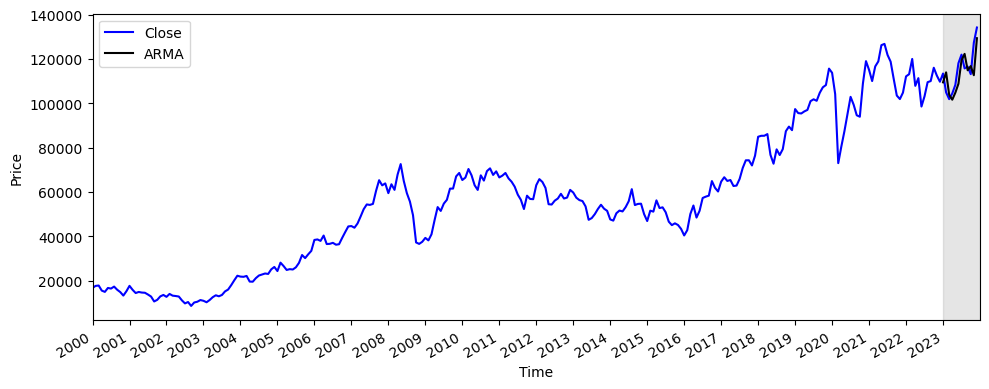

In [76]:
#===============================================================================================================================
# ARMA: Log-Diff - Recover - Price - Plot
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['Close'], 'b-', label='Close')    
#ax.plot(df.loc[testini:,'pred_Last'], 'r-' , label='Last')
#ax.plot(df.loc[testini:,'pred_Mean'], 'm-.', label='Mean')
#ax.plot(df.loc[testini:,'pred_MA']  , 'y-' , label='MA')   
#ax.plot(df.loc[testini:,'pred_AR']  , 'g-.', label='AR')   
ax.plot(df.loc[testini:,'pred_ARMA'], 'k-' , label='ARMA')   
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini, totallen)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

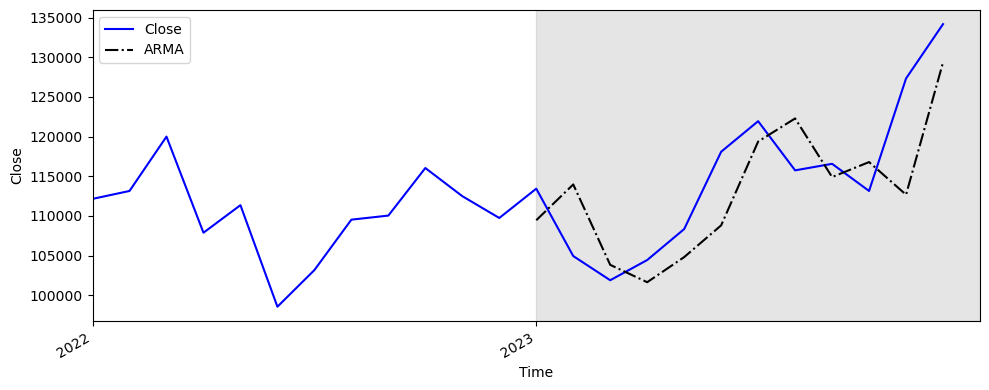

In [77]:
#===============================================================================================================================
# ARMA: Log-Diff - Recover - Price - Plot (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.loc[testini-testlen:,'Close']  , 'b-' , label='Close')
#ax.plot(df.loc[testini:,'pred_Last'], 'r-' , label='Last')
#ax.plot(df.loc[testini:,'pred_Mean'], 'm-.', label='Mean')
#ax.plot(df.loc[testini:,'pred_MA']  , 'y:' , label='MA')
#ax.plot(df.loc[testini:,'pred_AR']  , 'g:' , label='AR')
ax.plot(df.loc[testini:,'pred_ARMA'], 'k-.', label='ARMA')

ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Close')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini-testlen, totallen)
plt.xticks([ testini-testlen, testini],           ['2022'          , '2023'])
fig.autofmt_xdate()
plt.tight_layout()

In [78]:
################################################################################################################################
#
# ROLLING ARIMA
#
################################################################################################################################

In [79]:
#===============================================================================================================================
# ROLLING ARIMA: LIBRARIES
#===============================================================================================================================
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot

#===============================================================================================================================
# ROLLING ARIMA: LOG - LISTS
#===============================================================================================================================
CloseList = dfln['CloseLn'].values
CloseTrain, CloseTest = CloseList[0:trainlen], CloseList[testini:]
HistTrain = [x for x in CloseTrain]
PredTest = list()

In [80]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - AUTOARIMA - AIC
#===============================================================================================================================
import pandas as pd
import pmdarima as pmd

results = pmd.auto_arima(dfln['CloseLn'],
                         start_p=0,  # initial guess for AR(p)
                         start_d=0,  # initial guess for I(d)
                         start_q=0,  # initial guess for MA(q)
                         max_p=12,   # max guess for AR(p)
                         max_d=1,    # max guess for I(d)
                         max_q=12,   # max guess for MA(q)
                         trend='c',
                         information_criterion='aic',
                         trace=True,
                         error_action='ignore'
                         )

#-------------------------------------------------------------------------------------------------------------------------------
# AIC
#-------------------------------------------------------------------------------------------------------------------------------
# Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
#
#-------------------------------------------------------------------------------------------------------------------------------

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-697.580, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-699.010, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-699.538, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-697.580, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-698.057, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-698.458, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-696.938, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-699.538, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.873 seconds


In [81]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - AUTOARIMA - BIC
#===============================================================================================================================
results = pmd.auto_arima(dfln['CloseLn'],
                         start_p=0,  # initial guess for AR(p)
                         start_d=0,  # initial guess for I(d)
                         start_q=0,  # initial guess for MA(q)
                         max_p=12,    # max guess for AR(p)
                         max_d=1,    # max guess for I(d)
                         max_q=12,    # max guess for MA(q)
                         trend='c',
                         information_criterion='bic',
                         trace=True,
                         error_action='ignore'
                         )

#-------------------------------------------------------------------------------------------------------------------------------
# BIC
#-------------------------------------------------------------------------------------------------------------------------------
# Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
#
#-------------------------------------------------------------------------------------------------------------------------------

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=-690.261, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=-688.031, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=-688.560, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=-690.261, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=-683.419, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.358 seconds


In [82]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - FORECAST
#===============================================================================================================================
for t in range(testlen):
    # AIC - AKAIKE
    ARIMA_ROLL_model = SARIMAX(HistTrain, order=(0,1,1), simple_differencing=False)
    # BIC - BAYES
    #ARIMA_ROLL_model = SARIMAX(HistTrain, order=(0,1,0), simple_differencing=False)

    ARIMA_ROLL_model_fit = ARIMA_ROLL_model.fit(disp=False)

    output = ARIMA_ROLL_model_fit.forecast()
    yhat = output[0]
    PredTest.append(yhat)
    yobs = CloseTest[t]
    HistTrain.append(yobs)
    print('t = %d, Observed = %f, Forecast = %f' % (t, yobs, yhat))
    dfln.loc[trainlen+t,'pred_ARIMARLn'] = yhat
    

t = 0, Observed = 11.638946, Forecast = 11.603219
t = 1, Observed = 11.561067, Forecast = 11.643639
t = 2, Observed = 11.531573, Forecast = 11.550425
t = 3, Observed = 11.556288, Forecast = 11.529131
t = 4, Observed = 11.592984, Forecast = 11.559821
t = 5, Observed = 11.679177, Forecast = 11.597320
t = 6, Observed = 11.711309, Forecast = 11.690028
t = 7, Observed = 11.659117, Forecast = 11.714145
t = 8, Observed = 11.666206, Forecast = 11.651774
t = 9, Observed = 11.636414, Forecast = 11.668118
t = 10, Observed = 11.754546, Forecast = 11.632220
t = 11, Observed = 11.806977, Forecast = 11.770331


In [83]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - RESULTS
#===============================================================================================================================
#dfln.drop('pred_RARIMA', axis=1, inplace=True)
#dfln.rename(columns={"pred_RARIMALn": "pred_ARIMARLn"}, inplace=True)
dfln.loc[testini:,'pred_ARIMARLn'].to_excel('Data/Output/Rolling-Ln-Monthly-ARIMARLn(0,1,1).xlsx')
dfln.loc[testini-1:,['Date','Close', 'pred_ARIMARLn']]

,Date,Close,pred_ARIMARLn
275,2022-12-29,109734.60,NaN
276,2023-01-31,113430.54,11.603219
277,2023-02-28,104931.93,11.643639
278,2023-03-31,101882.20,11.550425
279,2023-04-28,104431.63,11.529131
280,2023-05-31,108335.07,11.559821
281,2023-06-30,118087.00,11.597320
282,2023-07-31,121942.98,11.690028
283,2023-08-31,115741.81,11.714145
284,2023-09-29,116565.17,11.651774


In [84]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - PERFORMANCE
#===============================================================================================================================
from sklearn.metrics import mean_squared_error
from math import sqrt

mse_Last        = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_LastLn'      ])
mse_Mean        = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MeanLn'      ])
mse_MA          = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MALn'        ])
mse_AR          = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_ARLn'        ])
mse_ARMA        = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_ARMALn'      ])
mse_ARIMAR      = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_ARIMARLn'    ])

data_metrics = [['Last'       , "{:,}".format(round(mse_Last     ,6)), "{:,}".format(round(sqrt(mse_Last)   ,6))] ,
                ['MA'         , "{:,}".format(round(mse_MA       ,6)), "{:,}".format(round(sqrt(mse_MA)     ,6))] ,
                ['AR'         , "{:,}".format(round(mse_AR       ,6)), "{:,}".format(round(sqrt(mse_AR)     ,6))] ,
                ['ARMA'       , "{:,}".format(round(mse_ARMA     ,6)), "{:,}".format(round(sqrt(mse_ARMA)   ,6))] ,
                ['ARIMAR'     , "{:,}".format(round(mse_ARIMAR   ,6)), "{:,}".format(round(sqrt(mse_ARIMAR) ,6))] ]

df_metrics = pd.DataFrame(data_metrics, columns=['Model', 'MSE', 'RMSE'])

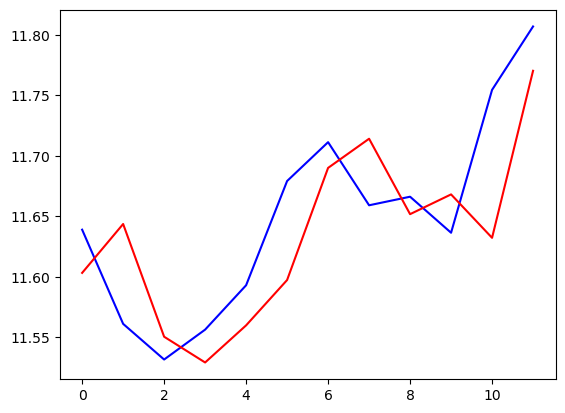

In [85]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - PLOT
#===============================================================================================================================
pyplot.plot(CloseTest, color='blue')
pyplot.plot(PredTest, color='red')
pyplot.show()

In [86]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - SUMMARY
#===============================================================================================================================
print(ARIMA_ROLL_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  287
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 349.986
Date:                Mon, 02 Dec 2024   AIC                           -695.973
Time:                        17:49:34   BIC                           -688.661
Sample:                             0   HQIC                          -693.042
                                - 287                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1292      0.049      2.659      0.008       0.034       0.224
sigma2         0.0051      0.000     16.275      0.000       0.004       0.006
Ljung-Box (L1) (Q):                   0.05   Jarque-

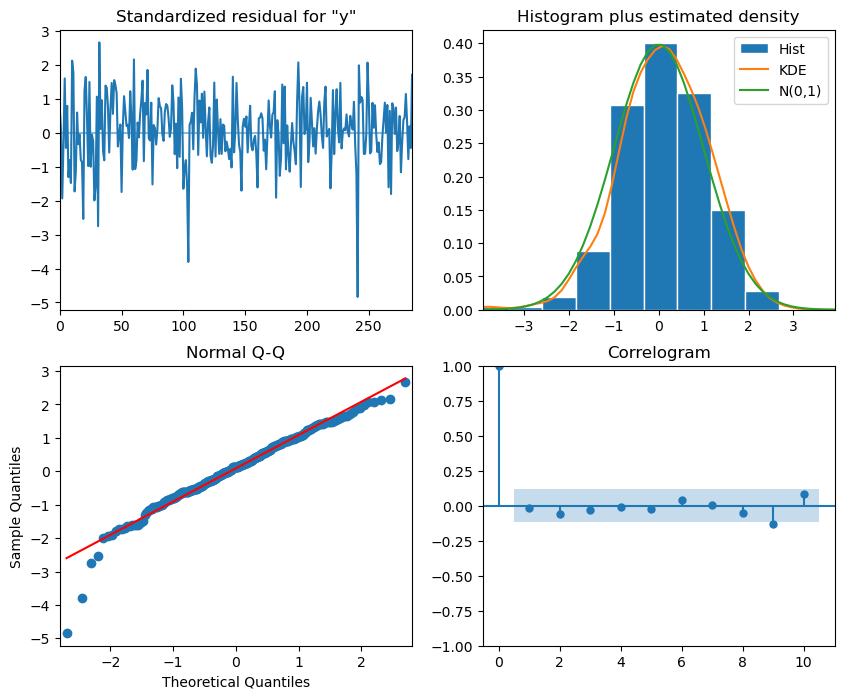

In [87]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - DIAGNOSTICS
#===============================================================================================================================
ARIMA_ROLL_model_fit.plot_diagnostics(figsize=(10,8));

#-------------------------------------------------------------------------------------------------------------------------------
#
# Residuals: No Trend, but Variance is not Constant (discrepancy to White Noise).
# Residuals: Distribution fairly close to a Normal distribution.
# Q-Q plot: Line fairly straight => distribution of Residuals close to a Normal distribution.
# Correlogram: No significant Coefficients after lag 0 => white noise.
#
#-------------------------------------------------------------------------------------------------------------------------------
# ***** WHITE NOISE *****
#-------------------------------------------------------------------------------------------------------------------------------

In [88]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - RESIDUALS - LJUNG-BOX test
#===============================================================================================================================
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

sm.stats.acorr_ljungbox(residuals, lags=[11], return_df=True)
#lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

#-------------------------------------------------------------------------------------------------------------------------------
# LJUNG-BOX test: pvalue > 0.05 => Residuals NOT CORRELATED
#-------------------------------------------------------------------------------------------------------------------------------
# ***** WHITE NOISE => Model can be used to FORECAST *****
#-------------------------------------------------------------------------------------------------------------------------------

,lb_stat,lb_pvalue
11,12.163611,0.351472


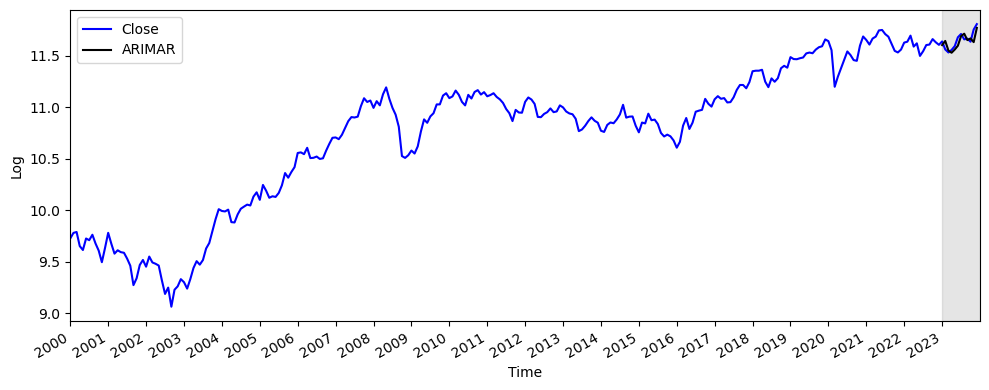

In [89]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dfln.loc[       :,'CloseLn']        , 'b-' , label='Close')
#ax.plot(dfln.loc[testini:,'pred_LastLn']    , 'y:' , label='Last')
#ax.plot(dfln.loc[testini:,'pred_ARMALn']    , 'w-.', label='ARMA')
ax.plot(dfln.loc[testini:,'pred_ARIMARLn']  , 'k-' , label='ARIMAR')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini, totallen)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

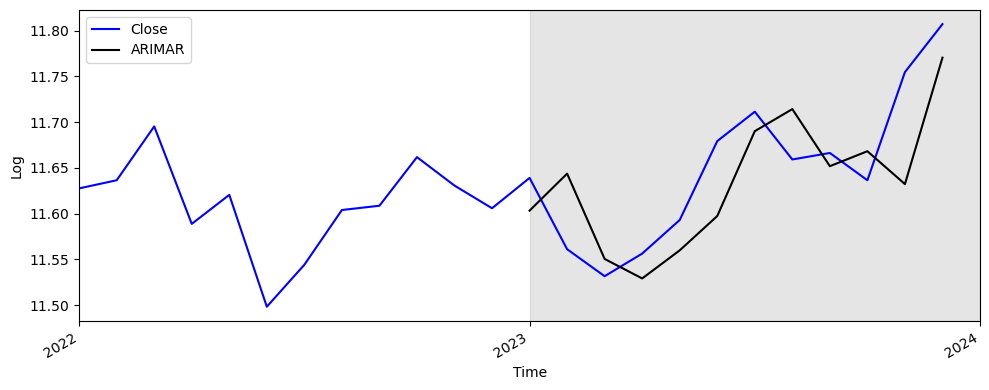

In [90]:
#===============================================================================================================================
# ROLLING ARIMA: LOG - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dfln.loc[testini-testlen:,'CloseLn'], 'b-' , label='Close')    
#ax.plot(dfln.loc[testini:,'pred_LastLn']    , 'y:' , label='Last')
#ax.plot(dfln.loc[testini:,'pred_ARMALn']    , 'w-.', label='ARMA')   
ax.plot(dfln.loc[testini:,'pred_ARIMARLn']  , 'k-' , label='ARIMAR')   
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini-testlen, totallen)
plt.xticks([testini-testlen, testini, totallen ], [ 2022, 2023, 2024])

fig.autofmt_xdate()
plt.tight_layout()

In [91]:
#===============================================================================================================================
# ROLLING ARIMA: PRICE - RECOVER
#===============================================================================================================================
df['pred_ARIMAR'] = 0.0
df.loc[testini:,'pred_ARIMAR']= np.round(np.exp(dfln.loc[testini:,'pred_ARIMARLn']),2)
df[testini-1:]

,Date,Close,pred_Last,pred_Mean,pred_MA,pred_AR,pred_ARMA,pred_ARIMAR
275,2022-12-29,109734.60,0.00,0.00,0.00,0.00,0.00,0.00
276,2023-01-31,113430.54,109734.60,55666.44,109449.87,109416.77,109449.87,109449.53
277,2023-02-28,104931.93,113430.54,55874.98,113963.19,113869.16,113963.19,113964.14
278,2023-03-31,101882.20,104931.93,56051.44,103823.20,103999.42,103823.20,103821.17
279,2023-04-28,104431.63,101882.20,56215.71,101633.90,101535.02,101633.90,101633.74
280,2023-05-31,108335.07,104431.63,56387.91,104800.63,104729.28,104800.63,104801.29
281,2023-06-30,118087.00,108335.07,56572.78,108805.12,108796.16,108805.12,108805.84
282,2023-07-31,121942.98,118087.00,56790.91,119373.31,119292.29,119373.31,119375.40
283,2023-08-31,115741.81,121942.98,57021.13,122289.06,122410.63,122289.06,122289.35
284,2023-09-29,116565.17,115741.81,57227.89,114896.48,115031.89,114896.48,114895.02


In [92]:
#===============================================================================================================================
# ROLLING ARIMA: PRICE - PERFORMANCE
#===============================================================================================================================
mse_Last   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Last'  ])
mse_Mean   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Mean'  ])
mse_MA     = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_MA'    ])
mse_AR     = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_AR'    ])
mse_ARMA   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_ARMA'  ])
#mse_ARIMA  = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_SARIMA'])
#mse_SARIMAS= mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_SARIMAS'])
mse_ARIMAR = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_ARIMAR'])

data_metrics = [['Last'      , "{:,}".format(round(mse_Last,))  , "{:,}".format(round(sqrt(mse_Last)   ,1))] ,
                ['MA'        , "{:,}".format(round(mse_MA,  ))  , "{:,}".format(round(sqrt(mse_MA)     ,1))] ,
                ['AR'        , "{:,}".format(round(mse_AR,  ))  , "{:,}".format(round(sqrt(mse_AR)     ,1))] ,
                ['ARMA'      , "{:,}".format(round(mse_ARMA,))  , "{:,}".format(round(sqrt(mse_ARMA)   ,1))] ,
                ['ARIMAR'    , "{:,}".format(round(mse_ARIMAR,)), "{:,}".format(round(sqrt(mse_ARIMAR) ,1))] ]
 
df_metrics = pd.DataFrame(data_metrics, columns=['Price', 'MSE', 'RMSE'])
df_metrics

,Price,MSE,RMSE
0,Last,"43,832,846","6,620.6"
1,MA,"42,620,739","6,528.5"
2,AR,"42,768,145","6,539.7"
3,ARMA,"42,620,739","6,528.5"
4,ARIMAR,"42,619,672","6,528.4"


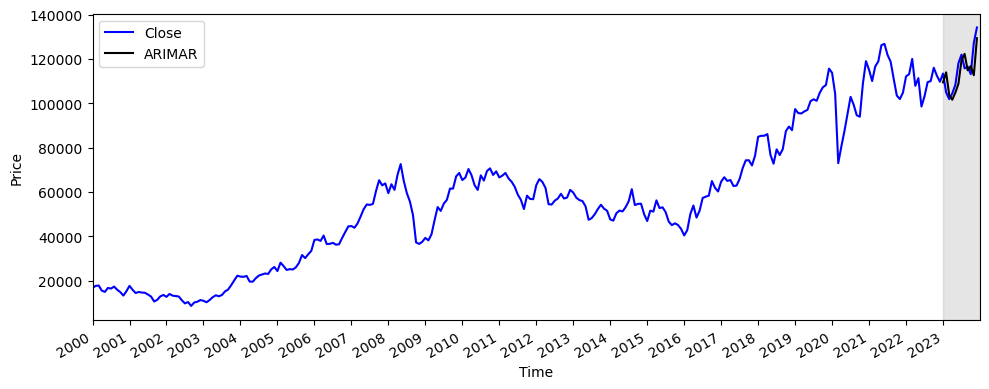

In [93]:
#===============================================================================================================================
# ROLLING ARIMA: PRICE - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['Close'], 'b-', label='Close')    
#ax.plot(df.loc[testini:,'pred_Last']   , 'r-' , label='Last')
#ax.plot(df.loc[testini:,'pred_Mean']   , 'm-.', label='Mean')
#ax.plot(df.loc[testini:,'pred_MA']     , 'y-' , label='MA')
#ax.plot(df.loc[testini:,'pred_AR']     , 'g-.', label='AR')
#ax.plot(df.loc[testini:,'pred_ARMA']   , 'k-' , label='ARMA')
ax.plot(df.loc[testini:,'pred_ARIMAR'] , 'k-' , label='ARIMAR')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini, totallen)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

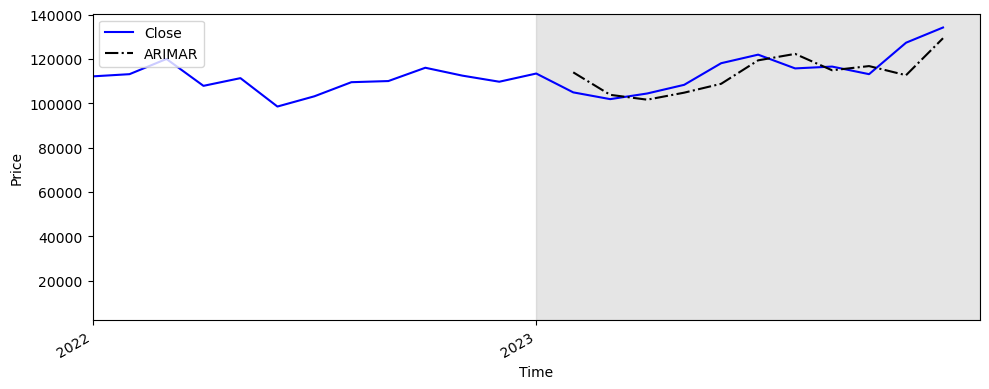

In [94]:
#===============================================================================================================================
# ROLLING ARIMA: PRICE - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.loc[testini-PERIOD:,'Close']    , 'b-' , label='Close')
#ax.plot(df.loc[testini+1:  ,'pred_Last']   , 'r-' , label='Last')
#ax.plot(df.loc[testini+1:  ,'pred_Mean']   , 'w-.', label='Mean')
#ax.plot(df.loc[testini+1:  ,'pred_MA']     , 'y-' , label='MA')
#ax.plot(df.loc[testini+1:  ,'pred_AR']     , 'g-.', label='AR')
#ax.plot(df.loc[testini+1:  ,'pred_ARMA']   , 'm-' , label='ARMA')
ax.plot(df.loc[testini+1:  ,'pred_ARIMAR'] , 'k-.', label='ARIMAR')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini, totallen)
plt.xticks([testini-testlen, testini], [2022, 2023])
fig.autofmt_xdate()
plt.tight_layout()

In [95]:
################################################################################################################################
#
# ROLLING ARIMA SEASONAL
#
################################################################################################################################

In [96]:
#===============================================================================================================================
# ROLLING ARIMA SEASONAL: LOG - AUTO_ARIMA - AIC
#===============================================================================================================================
import pandas as pd
import pmdarima as pmd

results = pmd.auto_arima(trainLn,
                         start_p=0,  # initial guess for AR(p)
                         start_d=0,  # initial guess for I(d)
                         start_q=0,  # initial guess for MA(q)
                         max_p=4,    # max guess for AR(p)
                         max_d=1,    # max guess for I(d)
                         max_q=4,    # max guess for MA(q)
                         m=12,        # seasonal order
                         start_P=0,  # initial guess for seasonal AR(P)
                         start_D=0,  # initial guess for seasonal I(D)
                         start_Q=0,  # initial guess for seasonal MA(Q)
                         trend='c',
                         information_criterion='aic',
                         trace=True,
                         error_action='ignore'
                         )

#-------------------------------------------------------------------------------------------------------------------------------
# Best model:  ARIMA(0,1,1)(0,0,0)[12] 
# AIC=-665.285
#-------------------------------------------------------------------------------------------------------------------------------

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-663.487, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-663.296, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-663.886, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-663.487, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-665.285, Time=0.07 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-663.812, Time=0.34 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-662.698, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-663.769, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=-664.134, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-664.781, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-662.680, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=-665.285, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12] intercept
Total fit time: 2.425 seconds


In [97]:
#===============================================================================================================================
# ROLLING ARIMA SEASONAL: LOG - AUTO_ARIMA - BIC
#===============================================================================================================================
results = pmd.auto_arima(trainLn,
                         start_p=0,  # initial guess for AR(p)
                         start_d=0,  # initial guess for I(d)
                         start_q=0,  # initial guess for MA(q)
                         max_p=4,    # max guess for AR(p)
                         max_d=1,    # max guess for I(d)
                         max_q=4,    # max guess for MA(q)
                         m=12,       # seasonal order
                         start_P=0,  # initial guess for seasonal AR(P)
                         start_D=0,  # initial guess for seasonal I(D)
                         start_Q=0,  # initial guess for seasonal MA(Q)
                         trend='c',
                         information_criterion='bic',
                         trace=True,
                         error_action='ignore'
                         )

#-------------------------------------------------------------------------------------------------------------------------------
# Best model:  ARIMA(0,1,0)(0,0,0)[12] 
# BIC=-656.253
#-------------------------------------------------------------------------------------------------------------------------------

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=-656.253, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=-648.829, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=-649.419, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=-656.253, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : BIC=-651.162, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : BIC=-651.235, Time=0.14 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : BIC=-646.107, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : BIC=-653.931, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : BIC=-654.435, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : BIC=-649.302, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 1.496 seconds


In [98]:
#===============================================================================================================================
# ROLLING ARIMA SEASONAL: LOG - LISTS
#===============================================================================================================================
CloseList = dfln['CloseLn'].values
CloseTrain, CloseTest = CloseList[:testini], CloseList[testini:]
HistTrain = [x for x in CloseTrain]
PredTest = list()

#===============================================================================================================================
# ROLLING ARIMA SEASONAL: LOG - FORECAST
#===============================================================================================================================
for t in range(testlen):
    SARIMA_ROLL_model = SARIMAX(HistTrain, order=(0,1,1), seasonal_order=(0,0,0,12), simple_differencing=False)
    
    SARIMA_ROLL_model_fit = SARIMA_ROLL_model.fit(disp=False)

    output = SARIMA_ROLL_model_fit.forecast()
    yhat = output[0]
    PredTest.append(yhat)
    yobs = CloseTest[t]
    #if t>1 : break
    HistTrain.append(yobs)
    print('t = %d, Estimation = %f, Observed = %f' % (t, yhat, yobs))
    dfln.loc[testini+t,'pred_SARIMARLn'] = yhat
    

t = 0, Estimation = 11.603219, Observed = 11.638946
t = 1, Estimation = 11.643639, Observed = 11.561067
t = 2, Estimation = 11.550425, Observed = 11.531573
t = 3, Estimation = 11.529131, Observed = 11.556288
t = 4, Estimation = 11.559821, Observed = 11.592984
t = 5, Estimation = 11.597320, Observed = 11.679177
t = 6, Estimation = 11.690028, Observed = 11.711309
t = 7, Estimation = 11.714145, Observed = 11.659117
t = 8, Estimation = 11.651774, Observed = 11.666206
t = 9, Estimation = 11.668118, Observed = 11.636414
t = 10, Estimation = 11.632220, Observed = 11.754546
t = 11, Estimation = 11.770331, Observed = 11.806977


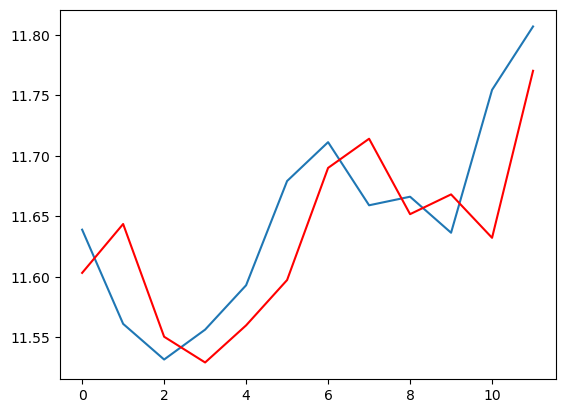

In [99]:
#===============================================================================================================================
# ROLLING ARIMA SEASONAL: LOG - PLOT
#===============================================================================================================================
pyplot.plot(CloseTest)
pyplot.plot(PredTest, color='red')
pyplot.show()


In [100]:
#===============================================================================================================================
# ROLLING ARIMA SEASONAL: LOG - SUMMARY
#===============================================================================================================================
print(SARIMA_ROLL_model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  287
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 349.986
Date:                Mon, 02 Dec 2024   AIC                           -695.973
Time:                        17:49:41   BIC                           -688.661
Sample:                             0   HQIC                          -693.042
                                - 287                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1292      0.049      2.659      0.008       0.034       0.224
sigma2         0.0051      0.000     16.275      0.000       0.004       0.006
Ljung-Box (L1) (Q):                   0.05   Jarque-

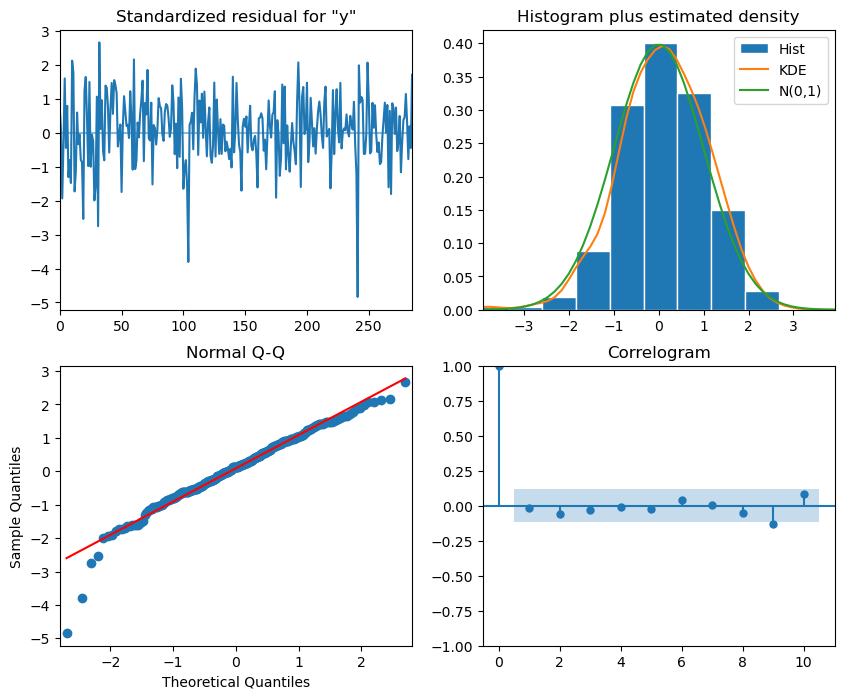

In [101]:
#===============================================================================================================================
# ROLLING ARIMA SEASONAL: LOG - DIAGNOSTICS
#===============================================================================================================================
SARIMA_ROLL_model_fit.plot_diagnostics(figsize=(10,8));

#-------------------------------------------------------------------------------------------------------------------------------
#
# Residuals: No Trend, but Variance is not Constant (discrepancy to White Noise).
# Residuals: Distribution fairly close to a Normal distribution.
# Q-Q plot: Line fairly straight => distribution of Residuals close to a Normal distribution.
# Correlogram: Only one significant Coefficients after lag 0, at lag 9 => close to White Noise.
#
# ***** ~ WHITE NOISE *****
#-------------------------------------------------------------------------------------------------------------------------------

In [102]:
#===============================================================================================================================
# ROLLING ARIMA SEASONAL: LOG - RESIDUALS - LJUNG-BOX test
#===============================================================================================================================
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
#residuals = model_fit.resid
residuals = SARIMA_ROLL_model_fit.resid
sm.stats.acorr_ljungbox(residuals, lags=[11], return_df=True)
#lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

#-------------------------------------------------------------------------------------------------------------------------------
#        lb_stat  lb_pvalue
#--------------------------
#  11   0.335199        1.0 (12)
#-------------------------------------------------------------------------------------------------------------------------------
# LJUNG-BOX test: pvalue > 0.05 => Residuals NOT CORRELATED.
#-------------------------------------------------------------------------------------------------------------------------------
# ***** WHITE NOISE => Model can be used to FORECAST *****
#-------------------------------------------------------------------------------------------------------------------------------

,lb_stat,lb_pvalue
11,0.285218,1.0


In [103]:
#===============================================================================================================================
# ROLLING ARIMA SEASONAL: LOG - RESULTS
#===============================================================================================================================
#dfln.rename(columns={"pred_SARIMAS_ROLLLn": "pred_SARIMARLn"}, inplace=True)
dfln.loc[testini:,'pred_SARIMARLn'].to_excel('Data/Output/Rolling-Ln-Monthly-SARIMARLn(0,1,1)(0,0,0,12).xlsx')
dfln[testini-1:]


,Date,Close,CloseLn,CloseLnDiff,pred_LastLn,pred_MeanLn,pred_MALn,pred_ARLn,pred_ARMALn,pred_ARIMARLn,pred_SARIMARLn
275,2022-12-29,109734.60,11.605820,-0.024764,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
276,2023-01-31,113430.54,11.638946,0.033126,11.605820,10.732902,11.603222,11.602919,11.603222,11.603219,11.603219
277,2023-02-28,104931.93,11.561067,-0.077879,11.638946,10.736173,11.643631,11.642805,11.643631,11.643639,11.643639
278,2023-03-31,101882.20,11.531573,-0.029495,11.561067,10.739140,11.550445,11.552141,11.550445,11.550425,11.550425
279,2023-04-28,104431.63,11.556288,0.024715,11.531573,10.741981,11.529132,11.528159,11.529132,11.529131,11.529131
280,2023-05-31,108335.07,11.592984,0.036696,11.556288,10.744889,11.559815,11.559134,11.559815,11.559821,11.559821
281,2023-06-30,118087.00,11.679177,0.086193,11.592984,10.747907,11.597314,11.597231,11.597314,11.597320,11.597320
282,2023-07-31,121942.98,11.711309,0.032132,11.679177,10.751209,11.690011,11.689332,11.690011,11.690028,11.690028
283,2023-08-31,115741.81,11.659117,-0.052192,11.711309,10.754602,11.714143,11.715136,11.714143,11.714145,11.714145
284,2023-09-29,116565.17,11.666206,0.007089,11.659117,10.757787,11.651787,11.652965,11.651787,11.651774,11.651774


In [104]:
#===============================================================================================================================
# ROLLING ARIMA SEASONAL: LOG - PERFORMANCE
#===============================================================================================================================
from sklearn.metrics import mean_squared_error
from math import sqrt

mse_Last        = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_LastLn'])
mse_Mean        = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MeanLn'])
mse_MA          = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_MALn'  ])
mse_AR          = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_ARLn'  ])
mse_ARMA        = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_ARMALn'])
mse_ARIMAR      = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_ARIMARLn'])
mse_SARIMAR     = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_SARIMARLn'])

data_metrics = [['Last'       , "{:,}".format(round(mse_Last       ,6)), "{:,}".format(round(sqrt(mse_Last)       ,6))] ,
                ['Mean'       , "{:,}".format(round(mse_Mean       ,6)), "{:,}".format(round(sqrt(mse_Mean)       ,6))] ,
                ['MA'         , "{:,}".format(round(mse_MA         ,6)), "{:,}".format(round(sqrt(mse_MA)         ,6))] ,
                ['AR'         , "{:,}".format(round(mse_AR         ,6)), "{:,}".format(round(sqrt(mse_AR)         ,6))] ,
                ['ARMA'       , "{:,}".format(round(mse_ARMA       ,6)), "{:,}".format(round(sqrt(mse_ARMA)       ,6))] ,
                ['ARIMAR'     , "{:,}".format(round(mse_ARIMAR     ,6)), "{:,}".format(round(sqrt(mse_ARIMAR)     ,6))] ,
                ['SARIMAR'    , "{:,}".format(round(mse_SARIMAR    ,6)), "{:,}".format(round(sqrt(mse_SARIMAR)    ,6))] ]

df_metrics = pd.DataFrame(data_metrics, columns=['Log', 'MSE', 'RMSE'])

C:\Users\55119\AppData\Local\Temp\ipykernel_1812\2039437400.py:14: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(testini, totallen-testlen)


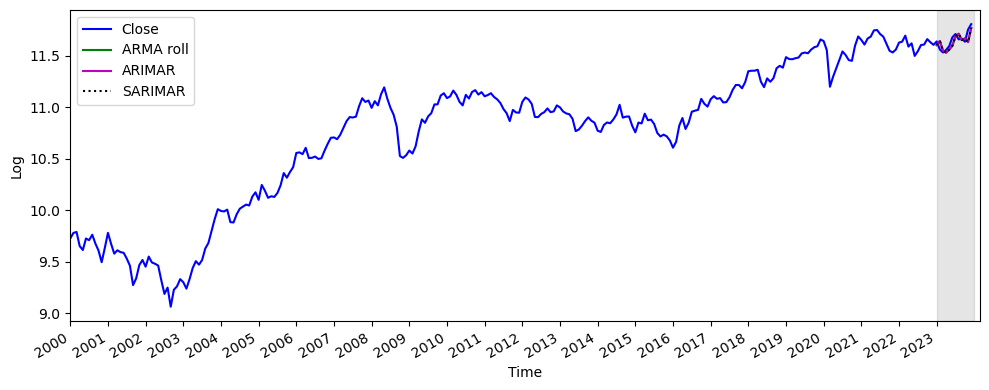

In [105]:
#===============================================================================================================================
# ROLLING SARIMA SEASONAL: LOG - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dfln.loc[:,'CloseLn']                       , 'b-', label='Close')    
#ax.plot(dfln.loc[testini:,'pred_LastLn']       , 'r:', label='Last')
ax.plot(dfln.loc[testini:,'pred_ARMALn']        , 'g-', label='ARMA roll')   
ax.plot(dfln.loc[testini:,'pred_ARIMARLn']  , 'm-', label='ARIMAR')   
ax.plot(dfln.loc[testini:,'pred_SARIMARLn'], 'k:', label='SARIMAR')   
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini, totallen-testlen)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

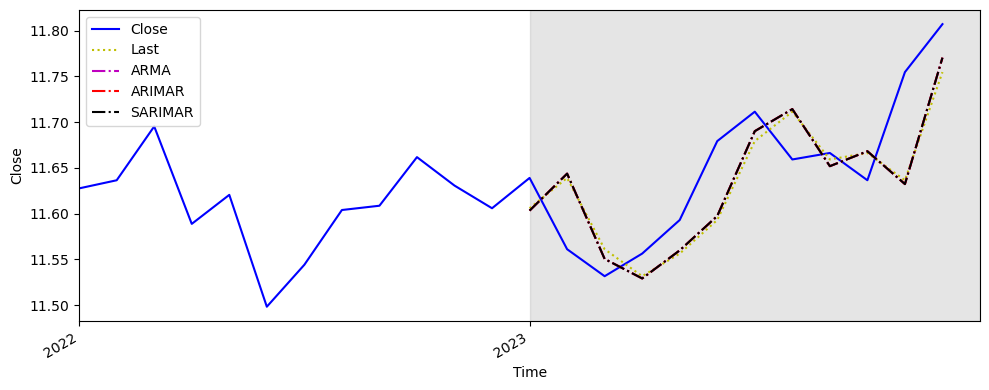

In [106]:
#===============================================================================================================================
# ROLLING SARIMA SEASONAL: LOG - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dfln.loc[testini-testlen: ,'CloseLn']        , 'b-',  label='Close')    
ax.plot(dfln.loc[testini:         ,'pred_LastLn']    , 'y:',  label='Last')    
ax.plot(dfln.loc[testini:         ,'pred_ARMALn']    , 'm-.', label='ARMA')   
ax.plot(dfln.loc[testini:         ,'pred_ARIMARLn']  , 'r-.', label='ARIMAR')   
ax.plot(dfln.loc[testini:         ,'pred_SARIMARLn'] , 'k-.', label='SARIMAR')   
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Close')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini-testlen, totallen) 
plt.xticks([ testini-testlen, testini ], [ 2022           , 2023])
fig.autofmt_xdate()
plt.tight_layout()

In [107]:
#===============================================================================================================================
# ROLLING ARIMA SEASONAL: PRICE - RECOVER
#===============================================================================================================================
df['pred_SARIMAR'] = 0.0
df.loc[testini:,'pred_SARIMAR']= np.round(np.exp(dfln.loc[testini:,'pred_SARIMARLn']),2)
dfln.loc[testini:,'pred_SARIMARLn'].to_excel('Data/Output/Rolling-Ln-Monthly-SARIMARLn.xlsx')
df[testini-1:]

,Date,Close,pred_Last,pred_Mean,pred_MA,pred_AR,pred_ARMA,pred_ARIMAR,pred_SARIMAR
275,2022-12-29,109734.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00
276,2023-01-31,113430.54,109734.60,55666.44,109449.87,109416.77,109449.87,109449.53,109449.53
277,2023-02-28,104931.93,113430.54,55874.98,113963.19,113869.16,113963.19,113964.14,113964.14
278,2023-03-31,101882.20,104931.93,56051.44,103823.20,103999.42,103823.20,103821.17,103821.17
279,2023-04-28,104431.63,101882.20,56215.71,101633.90,101535.02,101633.90,101633.74,101633.74
280,2023-05-31,108335.07,104431.63,56387.91,104800.63,104729.28,104800.63,104801.29,104801.29
281,2023-06-30,118087.00,108335.07,56572.78,108805.12,108796.16,108805.12,108805.84,108805.84
282,2023-07-31,121942.98,118087.00,56790.91,119373.31,119292.29,119373.31,119375.40,119375.40
283,2023-08-31,115741.81,121942.98,57021.13,122289.06,122410.63,122289.06,122289.35,122289.35
284,2023-09-29,116565.17,115741.81,57227.89,114896.48,115031.89,114896.48,114895.02,114895.02


In [108]:
#===============================================================================================================================
# ROLLING ARIMA SEASONAL: PRICE - PERFORMANCE
#===============================================================================================================================
mse_Last   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Last'])
mse_Mean   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Mean'])
mse_MA     = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_MA'  ])
mse_AR     = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_AR'  ])
mse_ARMA   = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_ARMA'])
mse_ARIMAR = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_ARIMAR'])
mse_SARIMAR= mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_SARIMAR'])

data_metrics = [['Last'      , "{:,}".format(round(mse_Last,))   , "{:,}".format(round(sqrt(mse_Last)   ,))] ,
                ['Mean'      , "{:,}".format(round(mse_Mean,))   , "{:,}".format(round(sqrt(mse_Mean)   ,))] ,
                ['MA'        , "{:,}".format(round(mse_MA,  ))   , "{:,}".format(round(sqrt(mse_MA)     ,))] ,
                ['AR'        , "{:,}".format(round(mse_AR,  ))   , "{:,}".format(round(sqrt(mse_AR)     ,))] ,
                ['ARMA'      , "{:,}".format(round(mse_ARMA,))   , "{:,}".format(round(sqrt(mse_ARMA)   ,))] ,
                ['ARIMAR'    , "{:,}".format(round(mse_ARIMAR,)) , "{:,}".format(round(sqrt(mse_ARIMAR) ,))] ,
                ['SARIMAR'   , "{:,}".format(round(mse_SARIMAR,)), "{:,}".format(round(sqrt(mse_SARIMAR),))] ]
 
df_metrics = pd.DataFrame(data_metrics, columns=['Price', 'MSE', 'RMSE'])
df_metrics

,Price,MSE,RMSE
0,Last,"43,832,846","6,621"
1,Mean,"3,470,811,963","58,914"
2,MA,"42,620,739","6,528"
3,AR,"42,768,145","6,540"
4,ARMA,"42,620,739","6,528"
5,ARIMAR,"42,619,672","6,528"
6,SARIMAR,"42,619,672","6,528"


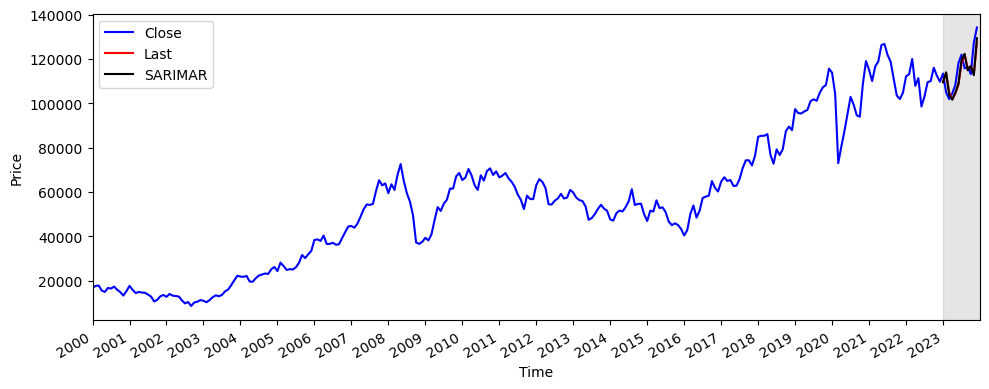

In [109]:
#===============================================================================================================================
# ROLLING ARIMA SEASONAL: PRICE - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['Close'], 'b-', label='Close')    
ax.plot(df.loc[testini:,'pred_Last']     , 'r-' , label='Last'    )
#ax.plot(df.loc[testini:,'pred_Mean']     , 'm-.', label='Mean'    )
#ax.plot(df.loc[testini:,'pred_MA']       , 'y-' , label='MA'      )   
#ax.plot(df.loc[testini:,'pred_AR']       , 'g-.', label='AR'      )   
#ax.plot(df.loc[testini:,'pred_ARMA']     , 'w-' , label='ARMA'    )   
#ax.plot(df.loc[testini:,'pred_ARIMAR']   , 'g-' , label='ARIMAR'  )   
ax.plot(df.loc[testini:,'pred_SARIMAR']  , 'k-' , label='SARIMAR' )   
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax.set_xlim(testini, totallen)
plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()

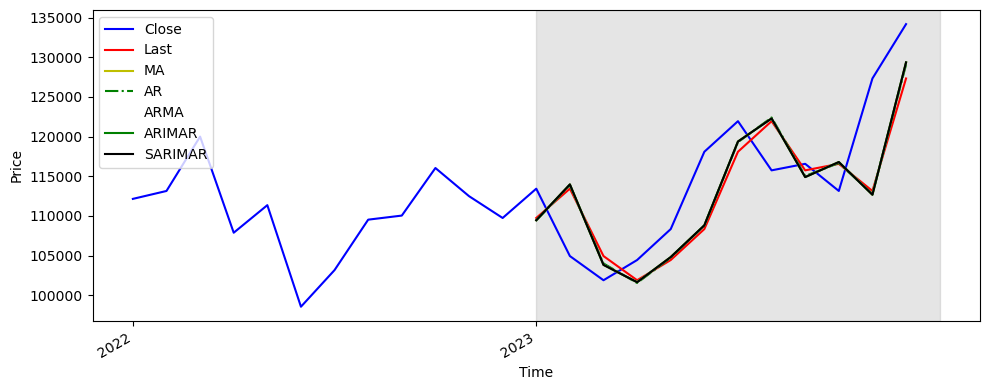

In [110]:
#===============================================================================================================================
# ROLLING ARIMA SEASONAL: PRICE - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.loc[testini-testlen:,'Close'] , 'b-' , label='Close')    
ax.plot(df.loc[testini:,'pred_Last']     , 'r-' , label='Last')
#ax.plot(df.loc[testini:,'pred_Mean']     , 'm-.', label='Mean')
ax.plot(df.loc[testini:,'pred_MA']       , 'y-' , label='MA')   
ax.plot(df.loc[testini:,'pred_AR']       , 'g-.', label='AR')   
ax.plot(df.loc[testini:,'pred_ARMA']     , 'w-' , label='ARMA')   
ax.plot(df.loc[testini:,'pred_ARIMAR']   , 'g-' , label='ARIMAR')   
ax.plot(df.loc[testini:,'pred_SARIMAR']  , 'k-' , label='SARIMAR')   
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
#ax.set_xlim(testini, totallen)
plt.xticks([ testini-testlen, testini],           ['2022'          , '2023'])
fig.autofmt_xdate()
plt.tight_layout()

